# Chapter 4 - Geocentric Models

In [1]:
%load_ext watermark

In [2]:
from functools import partial

import numpy as np
import arviz as az
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp

import scipy.stats as stats
from scipy.interpolate import griddata

import matplotlib.pyplot as plt

tfd = tfp.distributions

In [3]:
%watermark -p numpy,tensorflow,tensorflow_probability,arviz,scipy,pandas

numpy 1.18.1
tensorflow 2.1.0
tensorflow_probability 0.9.0
arviz 0.6.1
scipy 1.4.1
pandas 0.25.3


In [4]:
# config of various plotting libraries
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [5]:
# Helper functions to run MCMC Sampling

def trace_to_arviz(trace, sample_stats):
    posterior = {k: v.numpy() for k, v in trace.items()}
    sample_stats = {k: v.numpy().T for k, v in sample_stats.items()}
    return az.from_dict(posterior=posterior, sample_stats=sample_stats)

def nuts_trace_fn(current_state, pkr):
    return (
        pkr.inner_results.target_log_prob,
        pkr.inner_results.leapfrogs_taken,
        pkr.inner_results.has_divergence,
        pkr.inner_results.energy,
        pkr.inner_results.log_accept_ratio,
    )


@tf.function(autograph=False)
def run_nuts_chain(log_posterior, inits=dict(), step_size=0.1, burn_in=100, num_samples=1000):
    nuts_kernel = tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn=log_posterior, step_size=step_size)

    adapt_nuts_kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
        inner_kernel=nuts_kernel,
        num_adaptation_steps=burn_in,
        step_size_getter_fn=lambda pkr: pkr.step_size,
        log_accept_prob_getter_fn=lambda pkr: pkr.log_accept_ratio,
        step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(
            step_size=new_step_size)
    )

    results, sample_stats = tfp.mcmc.sample_chain(
        num_samples,
        current_state=inits.values(),
        kernel=adapt_nuts_kernel,
        num_burnin_steps=burn_in,
        trace_fn=nuts_trace_fn
    )

    return results, sample_stats


@tf.function
def run_hmc_chain(log_posterior, inits=dict(), step_size=1, burn_in=2000, num_samples=5000):
    
  adaptation_steps = int(0.5 * burn_in)
  
  hmc = tfp.mcmc.SimpleStepSizeAdaptation(
      # The actual HMC is very simple to define
      tfp.mcmc.HamiltonianMonteCarlo(
          target_log_prob_fn = log_posterior,    # Log Posterior goes here
          num_leapfrog_steps = 3,
          step_size = step_size                  # constant step size
      ),
      num_adaptation_steps = adaptation_steps
  )
    
  results = tfp.mcmc.sample_chain(
      num_results = num_samples,
      num_burnin_steps = burn_in,
      current_state = inits.values(),
      kernel = hmc,
      trace_fn=None
  )
  return results


def sample_mcmc_nuts(log_posterior, inits=dict(), step_size=0.1, burn_in=2000, num_samples=5000):
    results, sample_stats = run_nuts_chain(log_posterior, inits, step_size, burn_in, num_samples)
    stat_names = ["lp", "tree_size", "diverging", "energy", "mean_tree_accept"]
    if len(sample_stats) > len(stat_names):
        deterministic_values = sample_stats[len(stat_names):]
        sample_stats = sample_stats[: len(stat_names)]

    sampler_stats = dict(zip(stat_names, sample_stats))
    posterior = dict(zip(list(inits.keys()), results))
    return trace_to_arviz(posterior, sampler_stats)


def sample_mcmc_hmc(log_posterior, inits=dict(), step_size=0.1, burn_in=2000, num_samples=5000):
    results = run_hmc_chain(log_posterior, inits, step_size, burn_in, num_samples)
    return results

In [6]:
HOWELL_DATASET_PATH = "https://raw.githubusercontent.com/pymc-devs/resources/master/Rethinking/Data/Howell1.csv"

## Code 4.1

This snippet is showing the notion of "Normal distribution by Addition"

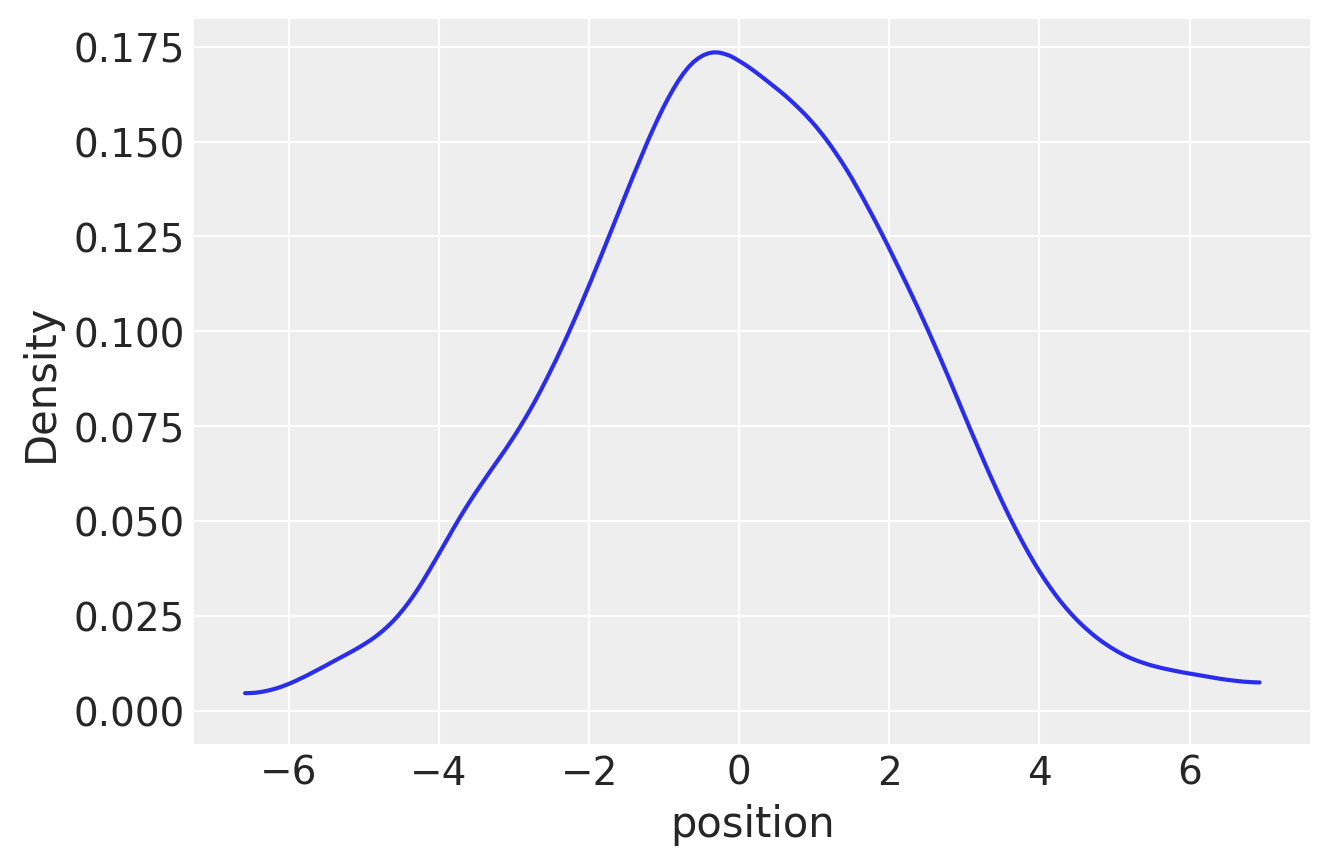

In [7]:
u1 = tfd.Uniform(low=-1.0, high=1.0)
pos = tf.reduce_sum(u1.sample(sample_shape=(16,1000)), axis=0)

az.plot_kde(pos)
plt.xlabel('position')
plt.ylabel('Density');

## Code 4.2 & 4.3

This snippet is showing the notion of "Normal distribution by Multiplication"

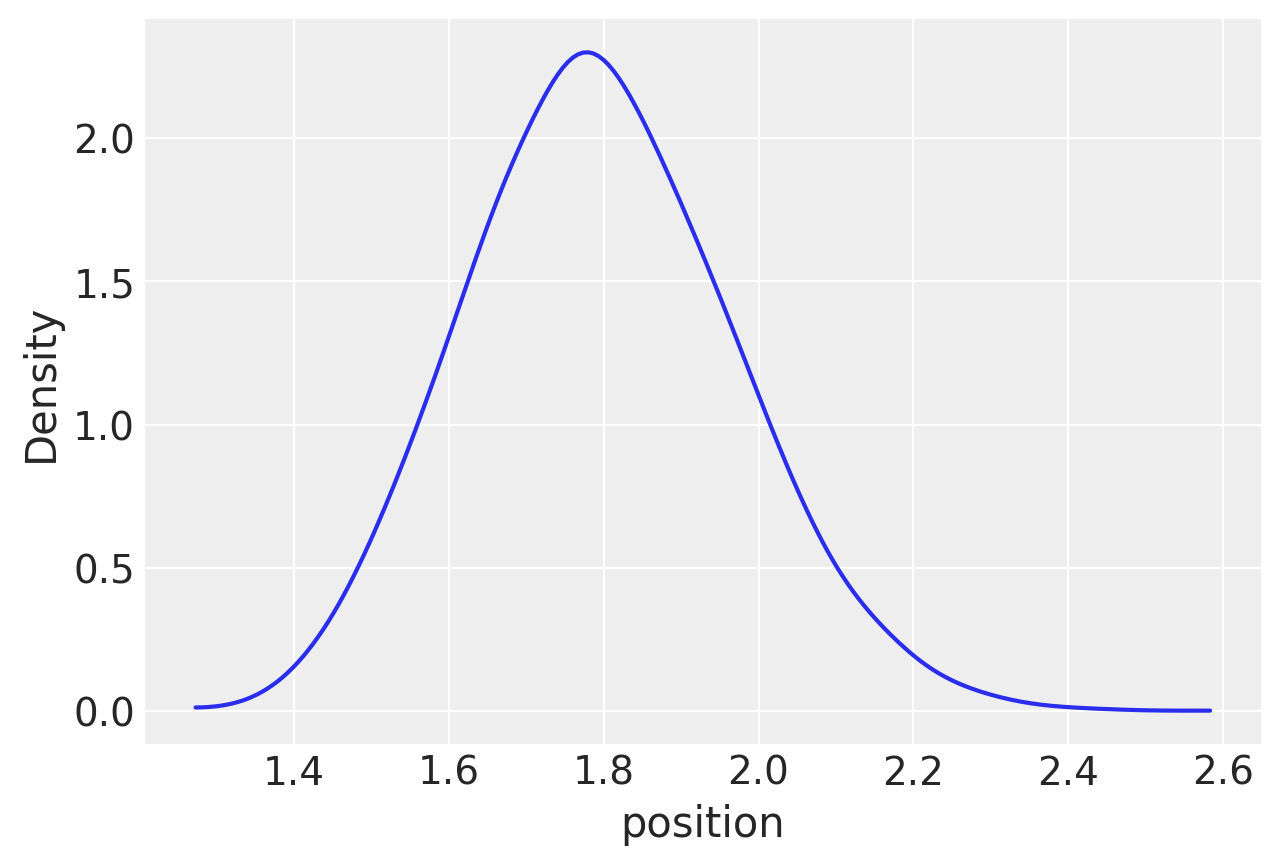

In [8]:
u2 = tfd.Uniform(low=1.0, high=1.1)
pos = tf.reduce_prod(u2.sample(sample_shape=(12,10000)), axis=0)

az.plot_kde(pos)
plt.xlabel('position')
plt.ylabel('Density');

## Code 4.4

Continuation of the notion of "Normal distribution by Multiplication"

Author explains that - "The smaller the effect of a variable (locus in the example), the better the additive approximation will be"

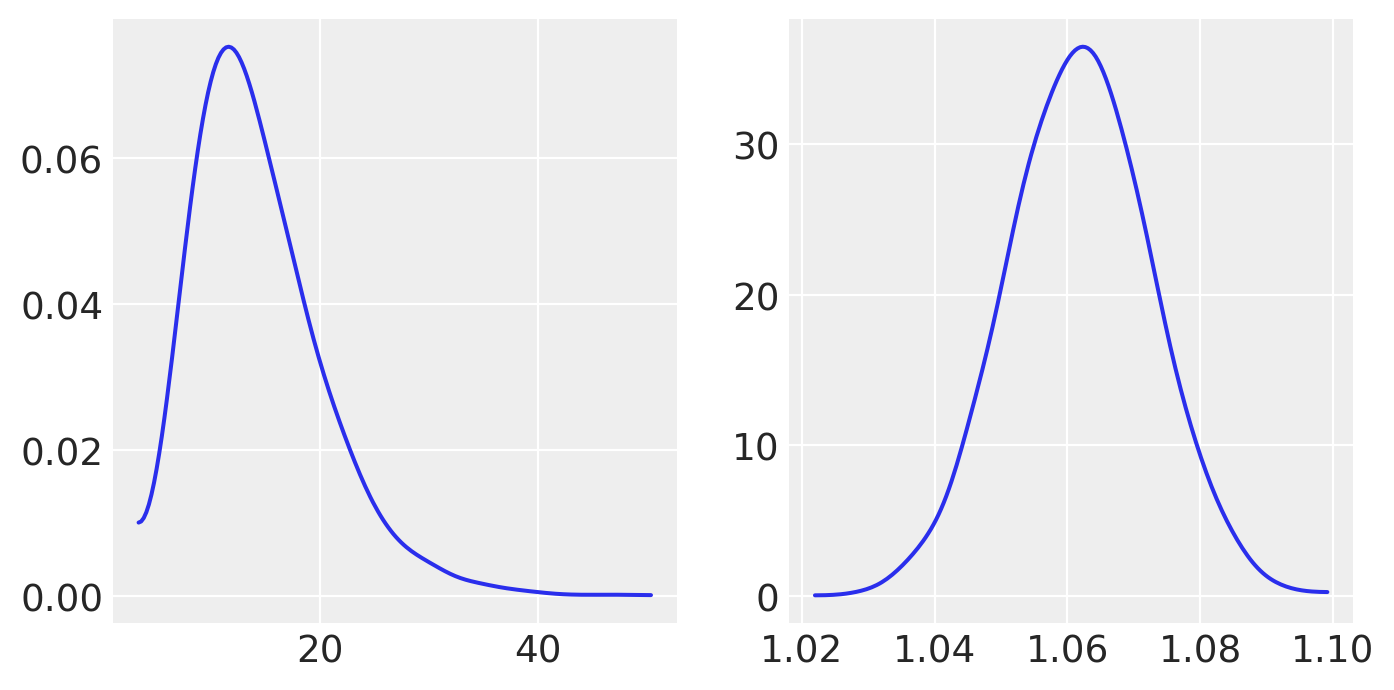

In [9]:
big =  tf.reduce_prod(tfd.Uniform(low=1.0, high=1.5).sample(sample_shape=(12,10000)), axis=0)
small =  tf.reduce_prod(tfd.Uniform(low=1.0, high=1.01).sample(sample_shape=(12,10000)), axis=0)

_, ax = plt.subplots(1,2, figsize=(8,4))
az.plot_kde(big, ax=ax[0])
az.plot_kde(small, ax=ax[1]);

## Code 4.5

This snippet is showing the notion of "Normal distribution by log-multiplication"

Author explains - "Large deviates that are multi- plied together do not produce Gaussian distributions, but they do tend to produce Gaussian distributions on the log scale. So even multiplicative interactions of large deviations can produce Gaussian distributions, once we measure the outcomes on the log scale."

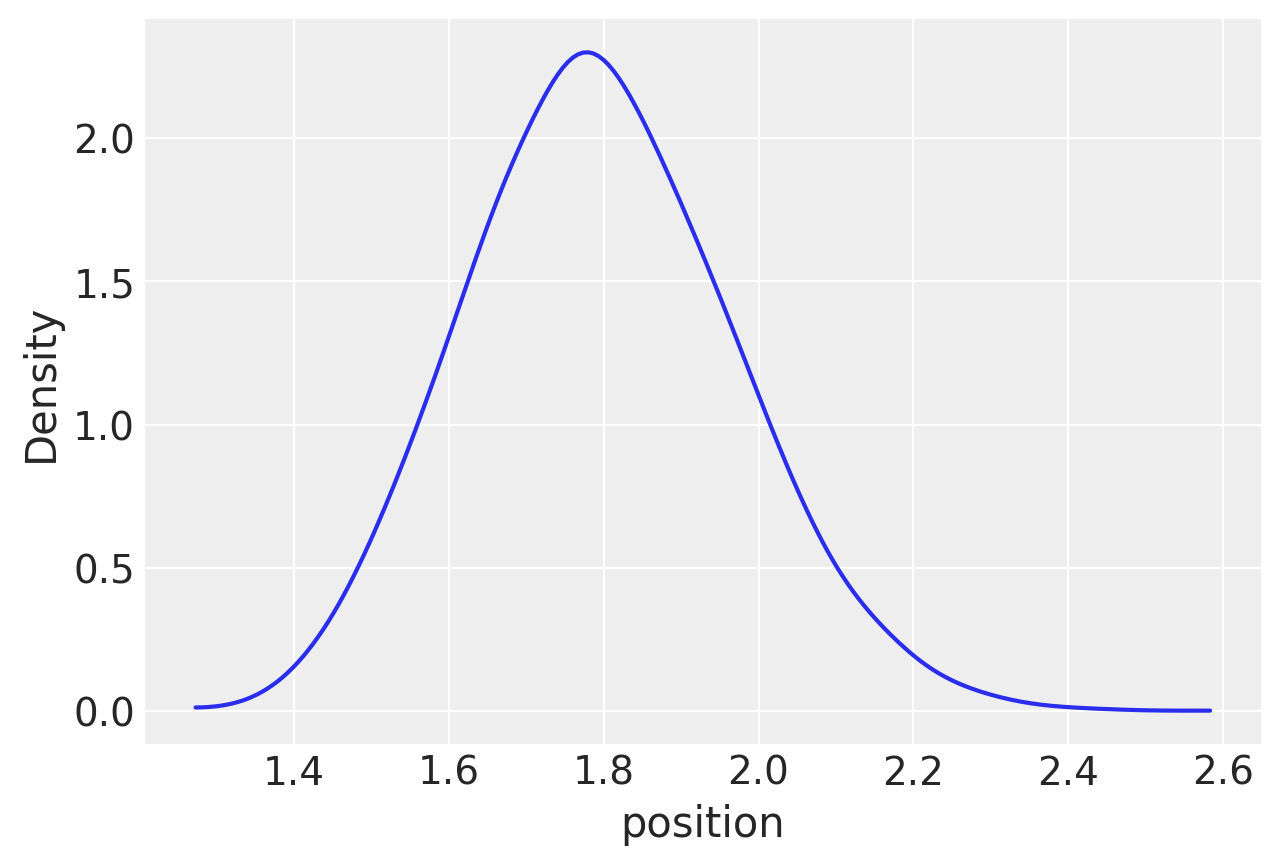

In [10]:
log_big = tf.math.log(tf.reduce_prod(tfd.Uniform(low=1.0, high=1.5).sample(sample_shape=(12,10000)), axis=0))
az.plot_kde(pos)
plt.xlabel('position')
plt.ylabel('Density');

## Code 4.6

Here the globe tossing model is described again.

$w$ = Observed count of water

$n$ = Total number of tosses

$p$ = Proportion of water on the globel


This is the first introduction/usage of Bayes' Theorem


Text(0, 0.5, 'Density')

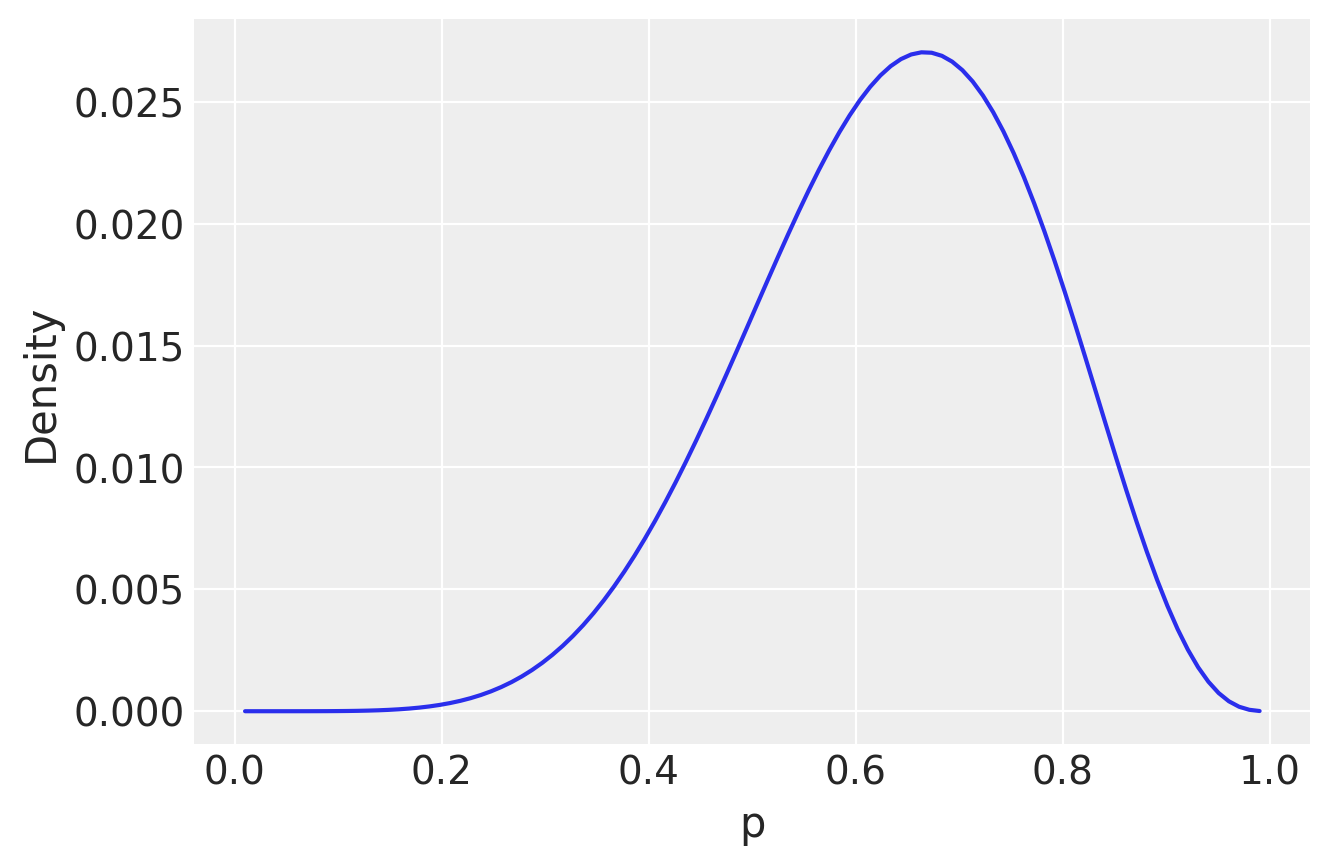

In [11]:
w, n = 6.0, 9.0

# TODO: Investigate, below does not work
# I have to change the bounds, see next line !
# p_grid = tf.linspace(0.0, 1.0, 100)
 
p_grid = tf.linspace(0.01, 0.99, 100)

b1_dist = tfd.Binomial(total_count=n, probs=p_grid)
u3_dist = tfd.Uniform(low=0.0, high=1.0)

posterior = b1_dist.prob(w) * u3_dist.prob(p_grid)
posterior = posterior / tf.reduce_sum(posterior)

plt.plot(p_grid, posterior)
plt.xlabel('p')
plt.ylabel('Density')

## Code 4.7, 4.8 


We are now building the Gaussian model of height


In [12]:
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


## Code 4.9

In [13]:
az.summary(d.to_dict(orient="list"), kind="stats")

,mean,sd,hpd_3%,hpd_97%
height,138.264,27.602,81.585,172.999
weight,35.611,14.719,7.201,55.282
age,29.344,20.747,0.000,65.300
male,0.472,0.500,0.000,1.000


## Code 4.10

For now we are going to work only with the height columns so let's look at it

In [14]:
d.height.head()

0    151.765
1    139.700
2    136.525
3    156.845
4    145.415
Name: height, dtype: float64

## Code 4.11

We are only interested in the heights of adults only (for the time being; we will incorporate the whole dataset later)

In [15]:
d2 = d[d.age >= 18]

## Code 4.12 & 4.13

Author explains that whatever is your prior, it's a very good idea to always plot it. This way we will have a better
sense of our model.

Here we have assumed certain values for our priors and as per the instruction plotting them

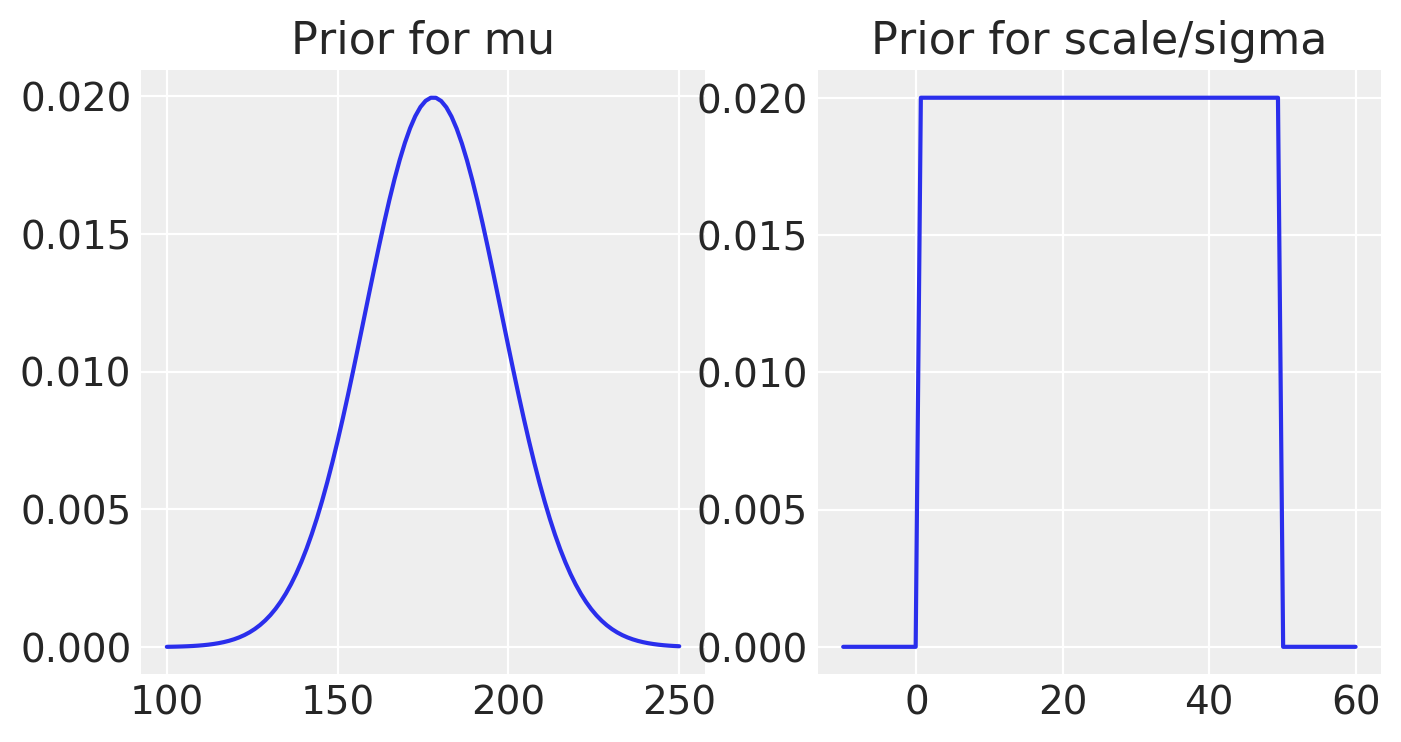

In [16]:
_, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))

x = tf.linspace(100.0, 250.0, 100)
mu_prior = tfd.Normal(loc=178.0, scale=20.0)
ax1.set_title('Prior for mu')
ax1.plot(x, mu_prior.prob(x));

x = tf.linspace(-10.0, 60.0, 100)
scale_prior = tfd.Uniform(low=0.0, high=50.0)
ax2.set_title('Prior for scale/sigma')
ax2.plot(x, scale_prior.prob(x))

## Code 4.14

In the above section we have chosen priors for $h$, $\mu$, $\sigma$ and even plotted them. It is also important to now see what kind of distribution these assumptions generate. This is called **PRIOR PREDICTIVE simulation** and is important part of modelling.

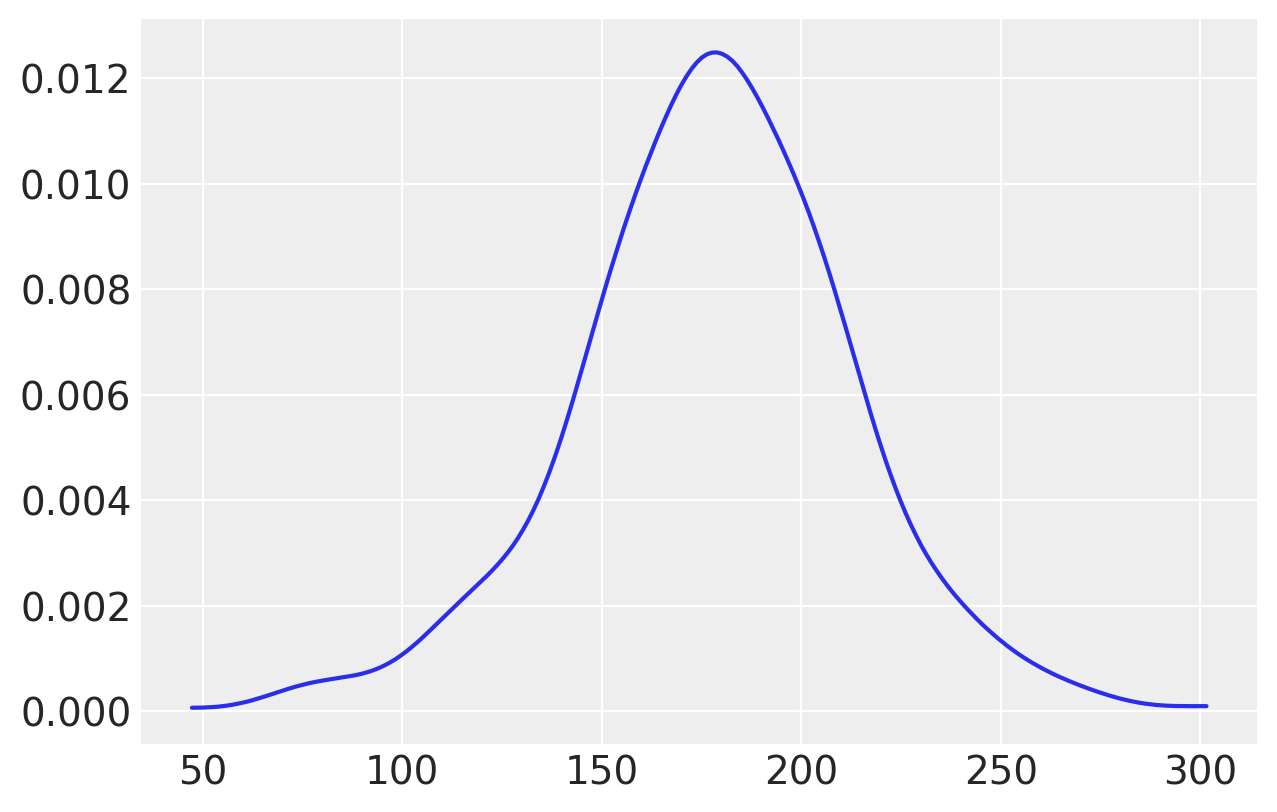

In [17]:
# plot the joint distribution of h, mu and sigma
n_samples = 1000

sample_mu = tfd.Normal(loc=178.0, scale=20.0).sample(n_samples)
sample_sigma = tfd.Uniform(low=0.0, high=50.0).sample(n_samples)
prior_h = tfd.Normal(loc=sample_mu, scale=sample_sigma).sample()

az.plot_kde(prior_h)

## Code 4.15

As mentioned in above cell the prior predictive simulation is helpful in assigning sensible priors. Here we see if we change the scale for *sample_mu* to 100 (instead of using 20 as in the above cell)

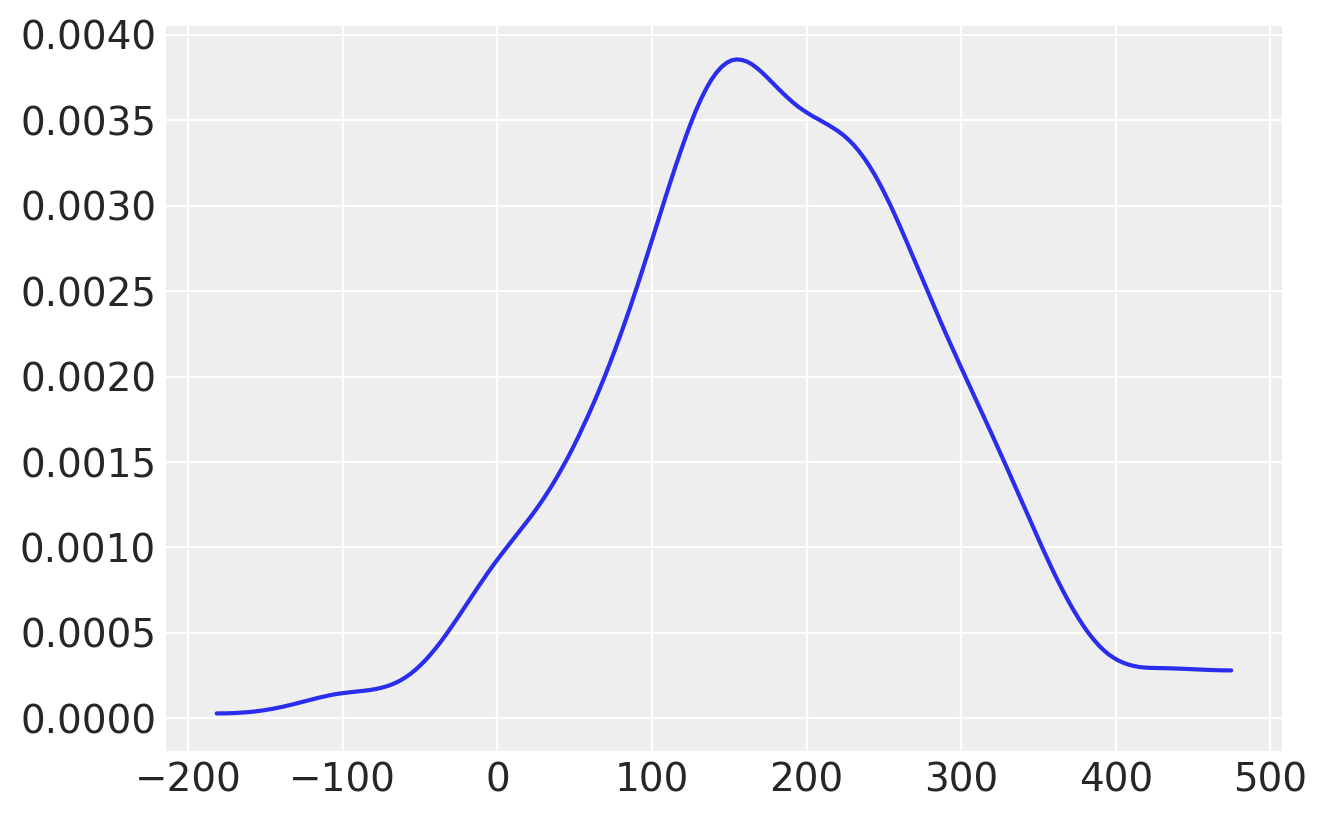

In [18]:
# plot the joint distribution of h, mu and sigma
n_samples = 1000

sample_mu = tfd.Normal(loc=178.0, scale=100.0).sample(n_samples)
sample_sigma = tfd.Uniform(low=0.0, high=50.0).sample(n_samples)
prior_h = tfd.Normal(loc=sample_mu, scale=sample_sigma).sample()

az.plot_kde(prior_h)

Now, what the above plot is showing that there are about 4% of people that have a **negative height** and about 18% on the right side have height not common at all for humans to attain ! So clearly this choice of scale (i.e. 100) is not a good one as the prior. 

## Code 4.16

Here we are doing **Grid approximation of the posterior distribution**. A very crude technique that may work for small/simple models. It is customary to do it to make a point but later we will use well established inference methods based on MCMC and VI

In [19]:
# We are here creating a grid of mu and sigma. In human speak it 
# means that we are generating all the possible combination of mu & sigma
#
# Since we have 2 dimensions we can represent the above combinations using
# a grid.

# TODO: Investigate using vectorized_map using tensorflow
def compute_liklihood(mu, sigma, sample_data):
    mu_ = mu.reshape(-1)
    sigma_ = sigma.reshape(-1)
    result = []
    # beauty of meshgrid is that we do not 
    # have to run the double loop
    for i in range(len(mu_)):
        norm_dist = tfd.Normal(loc=mu_[i], scale=sigma_[i])
        result.append(np.sum(norm_dist.log_prob(sample_data)))

    return np.array(result)

def grid_approximation(sample_data):

    mu_list = np.linspace(start=150, stop=160, num=200)
    sigma_list = np.linspace(start=7, stop=9, num=200)

    # TODO: Investigate meshgrid using tensorflow
    mesh = np.meshgrid(mu_list, sigma_list)

    log_liklihood = compute_liklihood(*mesh, sample_data)

    mu_ = mesh[0].reshape(-1)
    sigma_ = mesh[1].reshape(-1)

    logprob_mu = tfd.Normal(178.0, 20.0).log_prob(mu_)
    logprob_sigma = tfd.Uniform(low=0.0, high=50.0).log_prob(sigma_)

    log_joint_prod = log_liklihood + logprob_mu + logprob_sigma
    joint_prob = tf.exp(log_joint_prod - tf.reduce_max(log_joint_prod))
    
    return mesh, joint_prob


In [20]:
mesh, joint_prob = grid_approximation(d2.height.values)

## Code 4.17

Make a contour plot

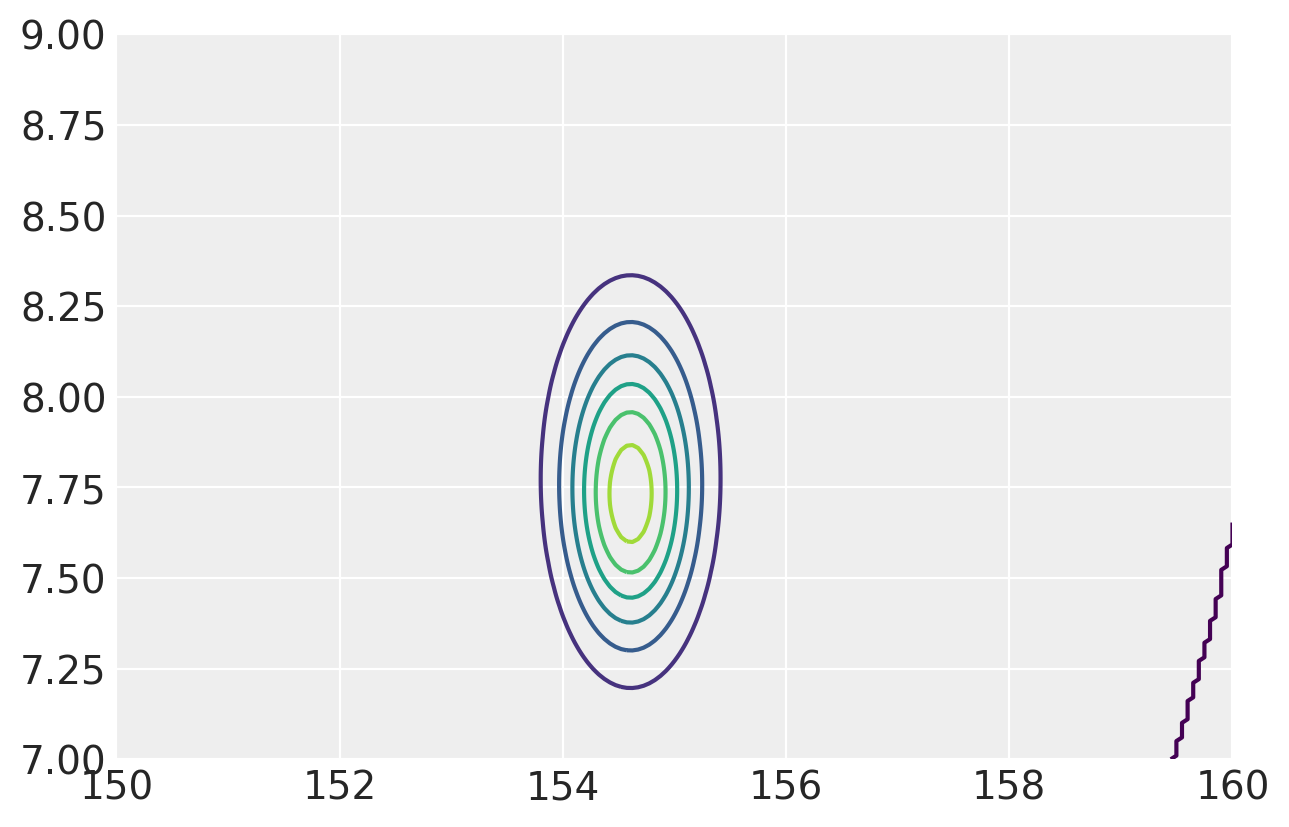

In [21]:
reshaped_joint_prob = tf.reshape(joint_prob, shape=(200,200))
plt.contour(*mesh, reshaped_joint_prob)

## Code 4.18

Here we are plotting a heatmap instead of contour plot

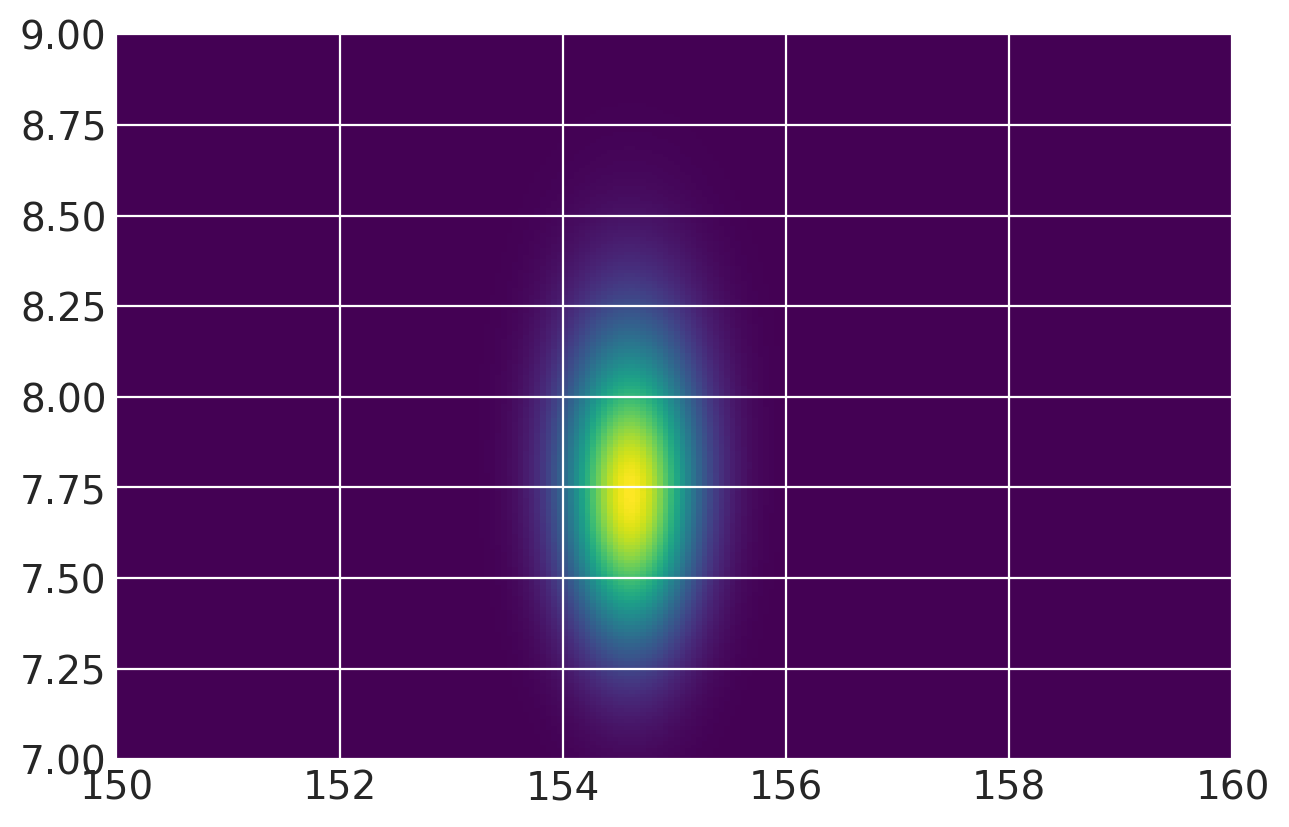

In [22]:
plt.imshow(reshaped_joint_prob,  origin="lower", extent=(150, 160, 7, 9), aspect="auto");

## Code 4.19 & 4.20

We are at point of now **Sampling from the Posterior**

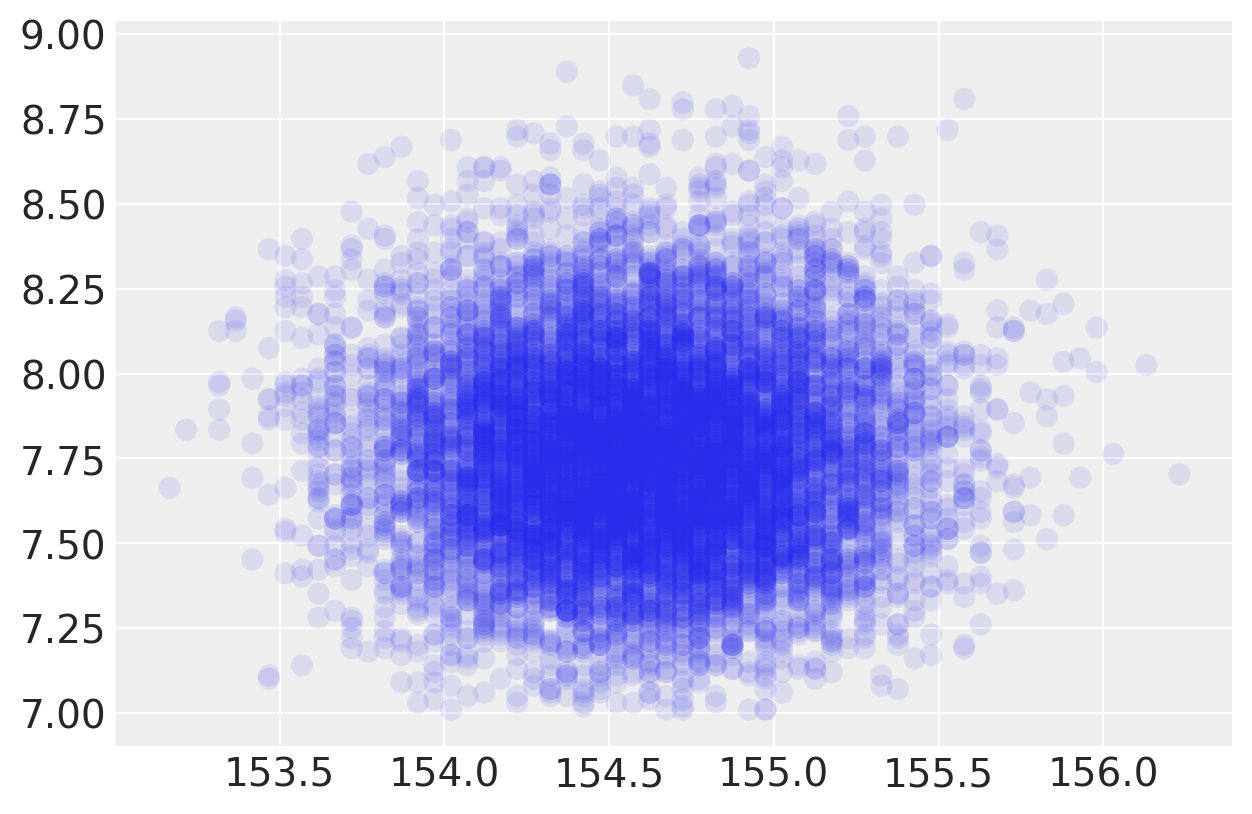

In [23]:
# This is a trick to sample row numbers randomly (and hence usage of Categorical)
sample_rows = tfd.Categorical(probs=(joint_prob/tf.reduce_sum(joint_prob))).sample(100_00)

mu_ = mesh[0].reshape(-1)
sigma_ = mesh[1].reshape(-1)

# We are sampling 2 parameters here from the selected rows
sample_mu = mu_[sample_rows]
sample_sigma = sigma_[sample_rows]


plt.scatter(sample_mu, sample_sigma, s=64, alpha=0.1, edgecolor="none");

## Code 4.21

Time to summarize/describe the distribution of confidence in each combination of $\mu$ & $\sigma$ using the samples.

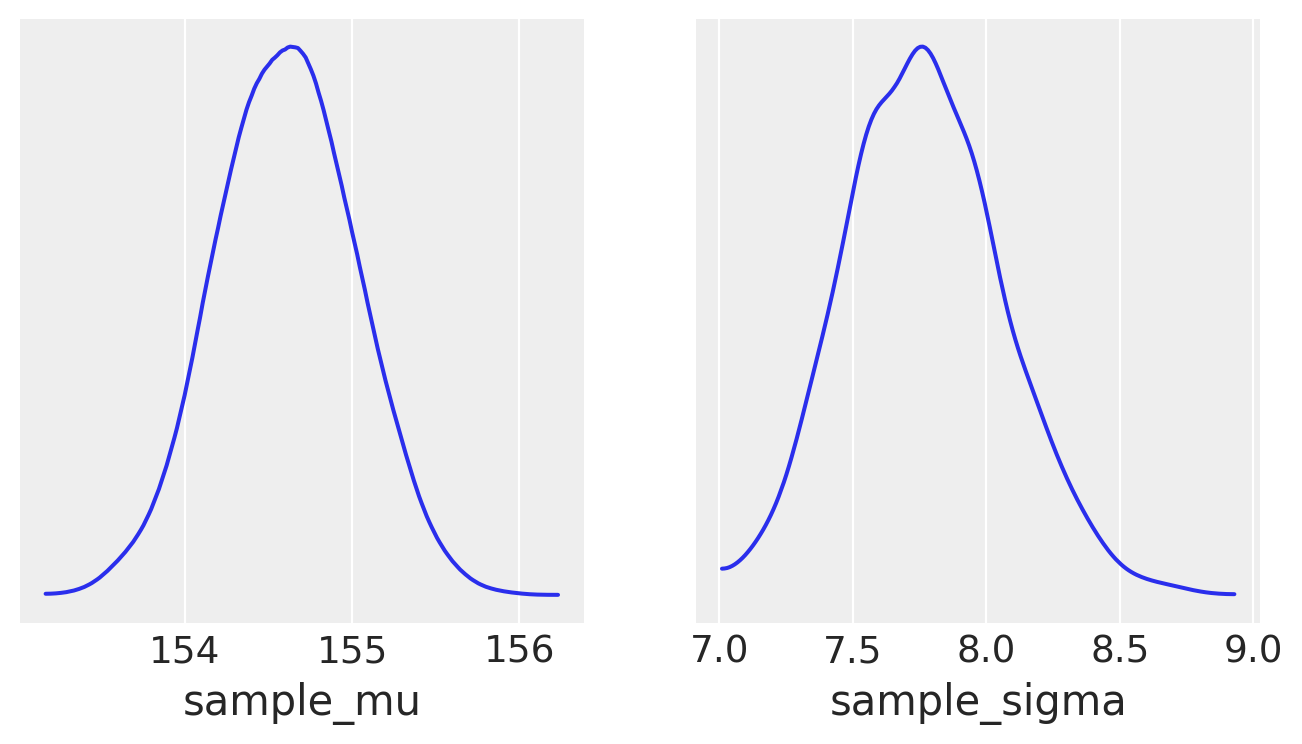

In [24]:
_, ax = plt.subplots(1,2, figsize=(8,4))
az.plot_kde(sample_mu, ax=ax[0])
ax[0].set_xlabel('sample_mu')
ax[0].set_yticks([])
az.plot_kde(sample_sigma, ax=ax[1])
ax[1].set_xlabel('sample_sigma')
ax[1].set_yticks([]);

As should be clear from the plot, the densities here are very close *normal distribution*. As sample size increases, posterior densities show this behavior. 

Pay attention to sample_sigma, density of it has a **longer right-hand tail**. Author mentions here that this condition is very common for standard deviation parameters. No explanation about it at this point of time.

## Code 4.22

Now we want to summarize the widths of these densities with **posterior compatibility intervals**

In [25]:
print("sample_mu -", az.hpd(sample_mu))
print("sample_sigma -", az.hpd(sample_sigma))

sample_mu - [153.86934673 155.37688442]
sample_sigma - [7.24120603 8.32663317]


## Code 4.23 & Code 4.24

Author now wants to use Quadratic approximation but he wants to make a point about using it and impact of $\sigma$ on this approximation.

Here the above analysis of the height data is repeated but with only a fraction of original data. The reasoning behind is to demonstrate that, in principle, the posterior is not always Gaussian in shape.

Author explains that for a Guassian $\mu$ & Gaussian likelihood the shape is always Gaussian irrespective of the sample size but it is the $\sigma$ that causes problems.

In [26]:
# We just get 20 samples for now and repeat our exercise
d3 = d2.height.sample(n=20)

In [27]:
mesh2, joint_prob2 = grid_approximation(d3.values)

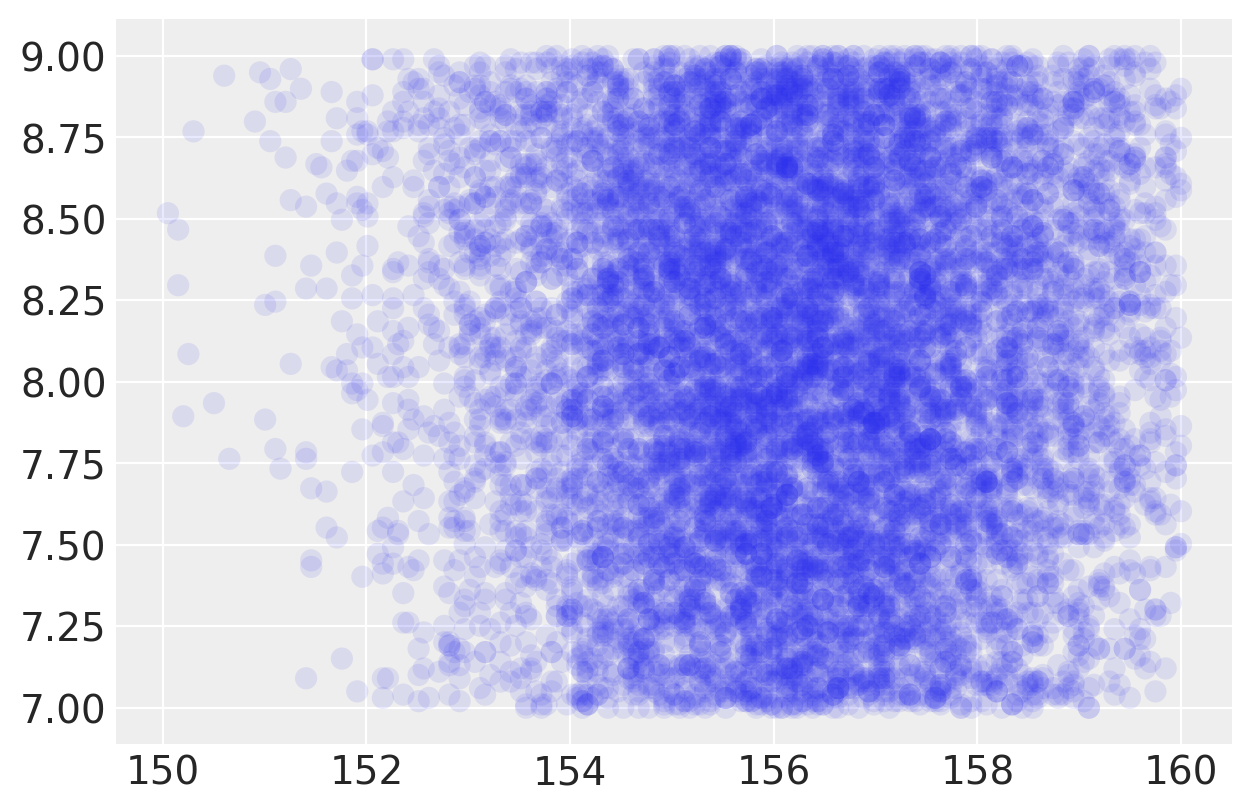

In [28]:
# This is a trick to sample row numbers randomly (and hence usage of Categorical)
sample2_rows = tfd.Categorical(probs=(joint_prob2/tf.reduce_sum(joint_prob2))).sample(100_00)

mu2_ = mesh2[0].reshape(-1)
sigma2_ = mesh2[1].reshape(-1)

# We are sampling 2 parameters here from the selected rows
sample2_mu = mu2_[sample2_rows]
sample2_sigma = sigma2_[sample2_rows]

plt.scatter(sample2_mu, sample2_sigma, s=64, alpha=0.1, edgecolor="none");

## Code 4.25

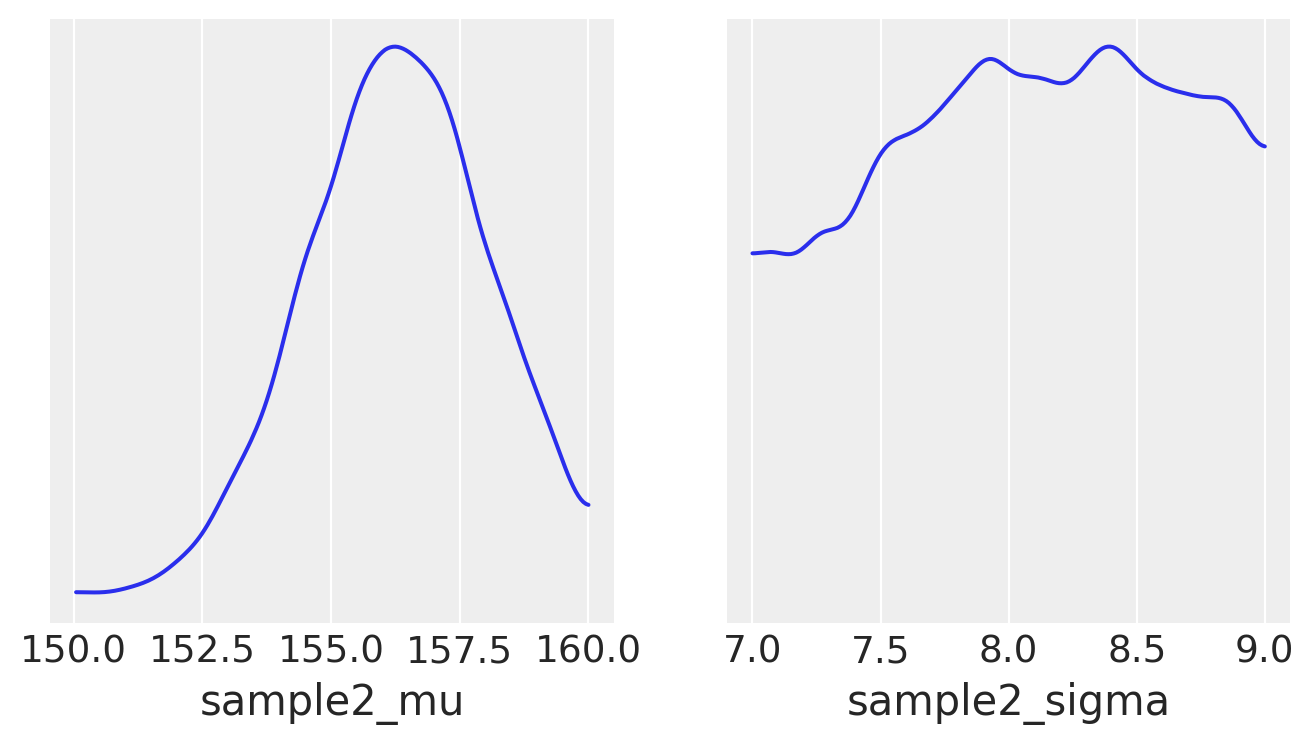

In [29]:
_, ax = plt.subplots(1,2, figsize=(8,4))
az.plot_kde(sample2_mu, ax=ax[0])
ax[0].set_xlabel('sample2_mu')
ax[0].set_yticks([])
az.plot_kde(sample2_sigma, ax=ax[1])
ax[1].set_xlabel('sample2_sigma')
ax[1].set_yticks([]);

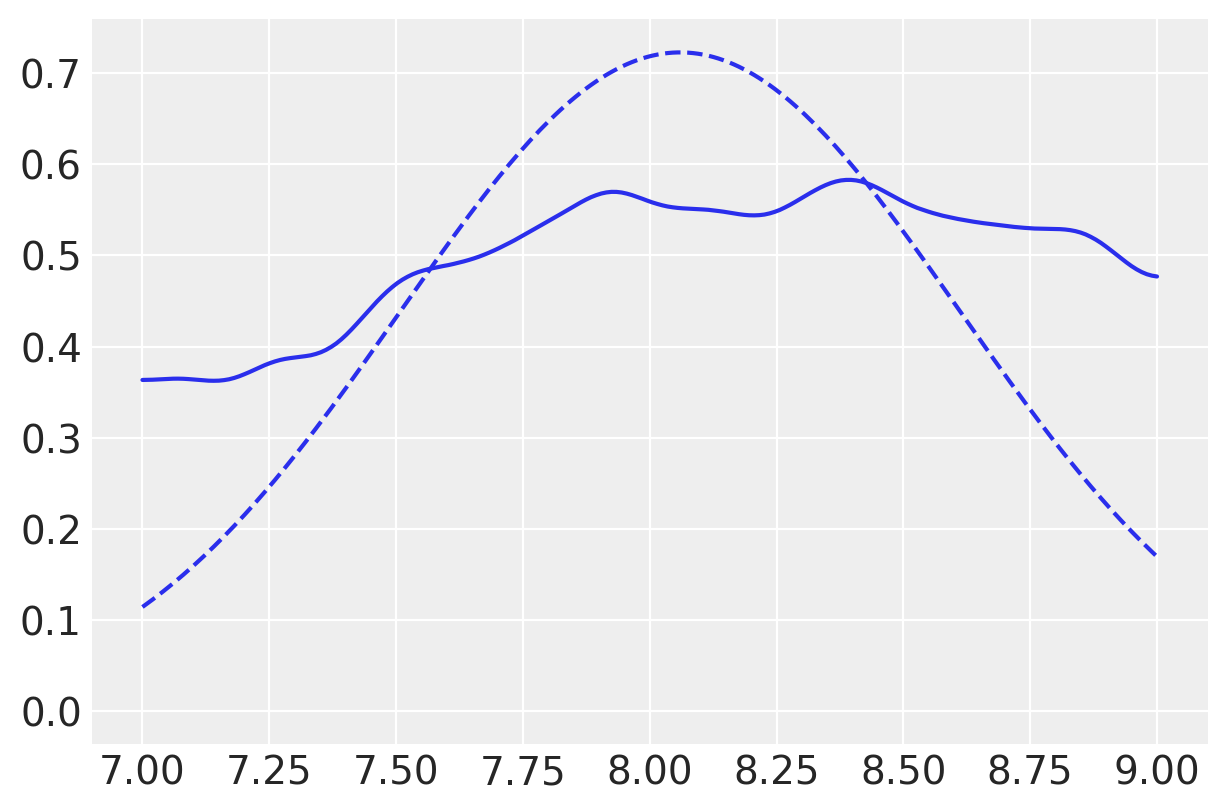

In [30]:
az.plot_kde(sample2_sigma)
x = np.sort(sample2_sigma)
plt.plot(x, np.exp(tfd.Normal(loc=np.mean(x), scale=np.std(x)).log_prob(x)), "--");

## Code 4.26

We will reload our data frame and start to use quadratic approximiation now

In [31]:
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
print(d.head())

d2 = d[d.age > 18]

d2

    height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041915  41.0     1
4  145.415  41.276872  51.0     0


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
534,162.560,47.031821,27.0,0
537,142.875,34.246196,31.0,0
540,162.560,52.163080,31.0,1
541,156.210,54.062496,21.0,0


## Code 4.27

We are now ready to define our model using tensorflow probability

In [32]:
def joint_log_prob_model(mu, sigma, data):
  mu_dist = tfd.Normal(loc=178., scale=20.)
  sigma_dist = tfd.Uniform(low=0., high=50.)
  height_dist = tfd.Normal(loc=mu, scale=sigma)
  
  return (
      mu_dist.log_prob(mu) +
      sigma_dist.log_prob(sigma) +           
      tf.reduce_sum(height_dist.log_prob(data)) 
  )

## Code 4.28

In [33]:
def unnormalized_posterior(mu, sigma):
    return joint_log_prob_model(mu, sigma, d2.height)

results = sample_mcmc_hmc(unnormalized_posterior, inits={ 'mu' : 120., 'sigma' : 4. })

In [34]:
results

[<tf.Tensor: shape=(5000,), dtype=float32, numpy=
 array([154.96034, 154.96034, 154.19028, ..., 154.87975, 154.87975,
        154.10625], dtype=float32)>,
 <tf.Tensor: shape=(5000,), dtype=float32, numpy=
 array([7.8624477, 7.8624477, 7.6612144, ..., 7.96771  , 7.96771  ,
        7.944992 ], dtype=float32)>]

## Code 4.29

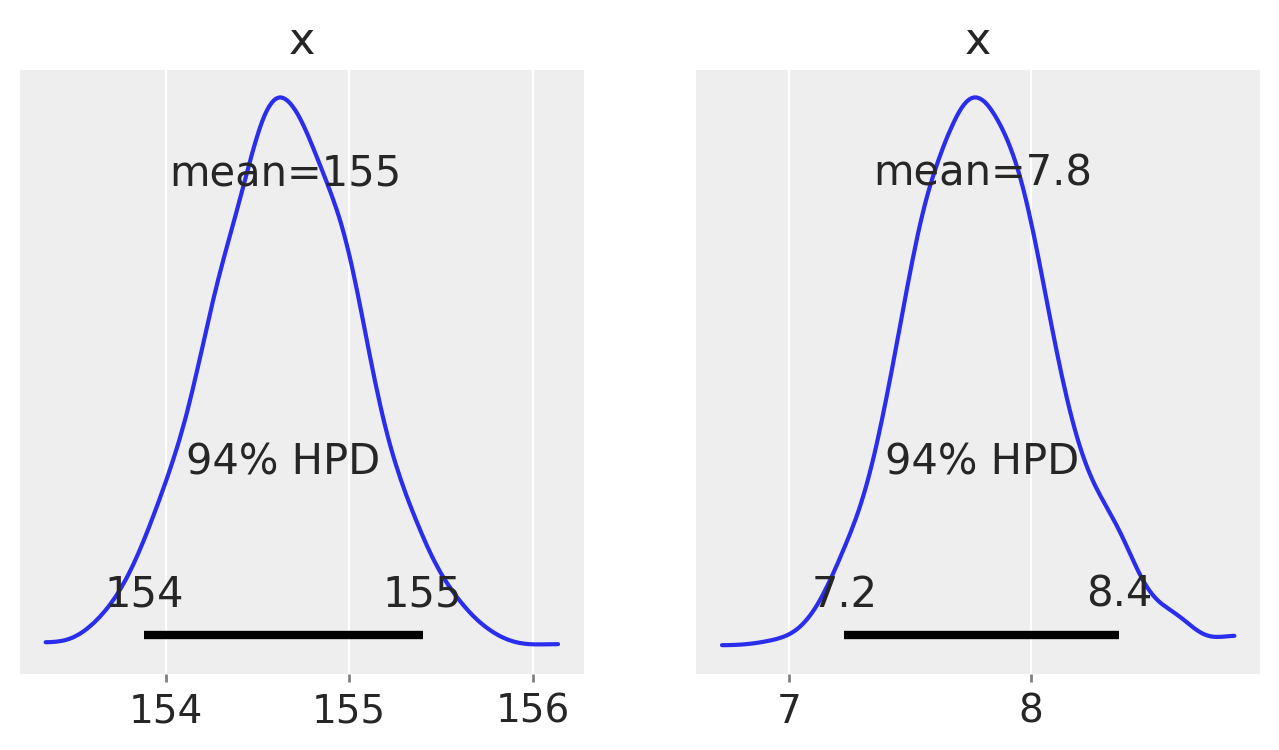

In [35]:
sample_mu, sample_sigma = results

_, ax = plt.subplots(1,2, figsize=(8,4))
az.plot_posterior(sample_mu.numpy(), ax=ax[0])
az.plot_posterior(sample_sigma.numpy(), ax=ax[1])

In [36]:
summary_dict = {
    'mu' : sample_mu.numpy(),
    'sigma' : sample_sigma.numpy()
}

az.summary(summary_dict, round_to=2, kind='stats')


,mean,sd,hpd_3%,hpd_97%
mu,154.65,0.4,153.88,155.40
sigma,7.80,0.3,7.23,8.36


These numbers shown above provide Gaussian approximations for each parameter’s marginal distribution.

## Code 4.30

What should be the starting values for the sampling ?

Author recommends that we could use the mean from the dataframe

In [37]:
height_mean = tf.cast(d2.height.mean(), dtype=tf.float32)
height_std = tf.cast(d2.height.std(), dtype=tf.float32)

print(f"Height mean {height_mean} and std {height_std}")

results = sample_mcmc_hmc(unnormalized_posterior, inits={'mu' : height_mean, 'sigma' : height_std})

Height mean 154.6443634033203 and std 7.773563861846924


## Code 4.31

In [38]:
# we are re-defining the model with different priors than before
def joint_log_prob_model2(mu, sigma, data):
  mu_dist = tfd.Normal(loc=178., scale=0.1)   # Only scale is different
  sigma_dist = tfd.Uniform(low=0., high=50.)
  height_dist = tfd.Normal(loc=mu, scale=sigma)
  
  return (
      mu_dist.log_prob(mu) +
      sigma_dist.log_prob(sigma) +           
      tf.reduce_sum(height_dist.log_prob(data)) 
  )


def unnormalized_posterior2(mu, sigma):
    return joint_log_prob_model2(mu, sigma, d2.height)

results2 = sample_mcmc_hmc(unnormalized_posterior2, inits={ 'mu': 120., 'sigma' : 4.})

sample2_mu, sample2_sigma = results2

summary_dict = {
    'mu' : sample2_mu.numpy(),
    'sigma' : sample2_sigma.numpy()
}

az.summary(summary_dict, round_to=2, kind='stats')

,mean,sd,hpd_3%,hpd_97%
mu,177.87,0.10,177.68,178.05
sigma,24.62,0.95,22.90,26.50


Taken verbatim from the book :

Notice that the estimate for μ has hardly moved off the prior. The prior was very concentrated around 178. So this is not surprising. But also notice that the estimate for σ has changed quite a lot, even though we didn’t change its prior at all. Once the golem is certain that the mean is near 178—as the prior insists—then the golem has to estimate σ conditional on that fact. This results in a different posterior for σ, even though all we changed is prior information about the other parameter.

## Code 4.32


Now this approximation of posterior is multi-dimension where $\mu$ and $\sigma$ are contributing a dimension each. In other words, we have a multi-dimensional gaussian distribution

Since it is multi-dimensional, let's see the covariances between the parameters

In [39]:
sample_mu, sample_sigma = results

vcov = np.cov(np.stack([sample_mu, sample_sigma], axis=0))
vcov

array([[ 0.18062838, -0.00291319],
       [-0.00291319,  0.08736162]])

## Code 4.33

In [40]:
print(np.diagonal(vcov))
print(vcov / np.sqrt(np.outer(np.diagonal(vcov), np.diagonal(vcov))))

[0.18062838 0.08736162]
[[ 1.         -0.02319075]
 [-0.02319075  1.        ]]


## Code 4.34

We did not use the quadratic approximation, instead we use a MCMC method to sample from the posterior. Thus, we already have samples. We can do something like

In [41]:
sample_sigma[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([7.7700543, 7.949011 , 7.949011 , 8.2064495, 8.2064495, 8.2064495,
       8.2064495, 8.502445 , 8.713125 , 8.713125 ], dtype=float32)>

## Code 4.35

In [42]:
az.summary({
    'mu' : sample_mu.numpy(),
    'sigma' : sample_sigma.numpy()
}, round_to=2, kind="stats")

,mean,sd,hpd_3%,hpd_97%
mu,154.66,0.43,153.84,155.42
sigma,7.81,0.30,7.26,8.33


## Code 4.36

In [43]:
samples_flat = np.stack([sample_mu, sample_sigma], axis=0)
mu_mean = np.mean(sample_mu, dtype=np.float64)
sigma_mean = np.mean(sample_sigma, dtype=np.float64)
cov = np.cov(samples_flat)

mu_mean, sigma_mean, cov

(154.66097174682616, 7.810198454475403, array([[ 0.18062838, -0.00291319],
        [-0.00291319,  0.08736162]]))

In [44]:
mvn = tfd.MultivariateNormalFullCovariance(
    loc=[mu_mean, sigma_mean],
    covariance_matrix=cov)

mvn.sample(1000)

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


<tf.Tensor: shape=(1000, 2), dtype=float64, numpy=
array([[154.81434732,   7.89423309],
       [154.11152593,   7.43767941],
       [154.42453894,   8.04526032],
       ...,
       [154.44710752,   7.65549563],
       [154.88739128,   7.63713743],
       [154.5717792 ,   7.6379546 ]])>

## Code 4.37

So now let’s look at how height in these Kalahari foragers (the outcome variable) covaries with weight (the predictor variable).

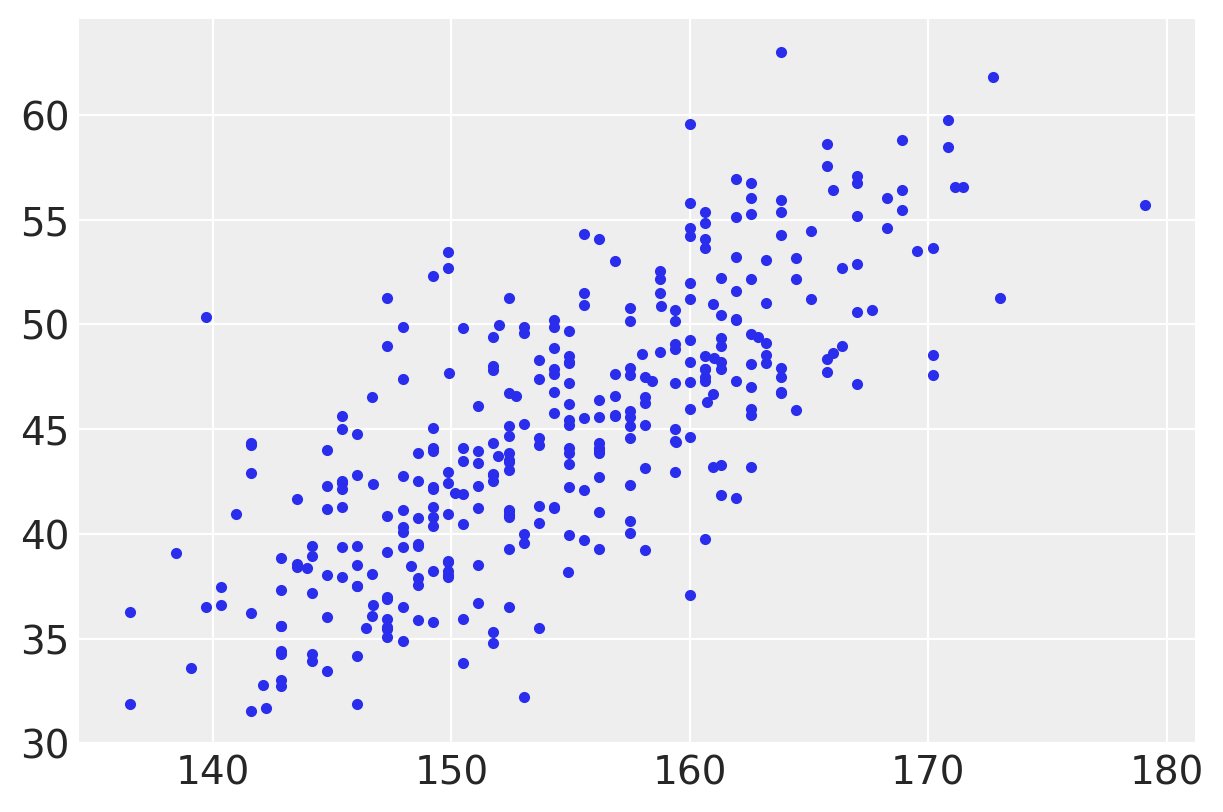

In [45]:
plt.plot(d2.height, d2.weight, ".");

The plot clearly shows a relationship between weight and height.

## Code 4.38, & 4.39 


This snippet is in the section titled - "The linear model strategy". The section is a master piece and clearly explains the conceptual meaning of *intercept* and *slope* in linear models. Read the section thoroughly with a cup of tea and it will make your day !.

In brief, we have now started to model the relation between height & weight formally and the strategy is formally Linear Model and process is called Linear Regression. 

Here is the description of the model -

$h_i \sim Normal(\mu_i,\sigma)$    

$\mu_i = \alpha + \beta(x_i - \bar{x})$   

$\alpha \sim Normal(178,20)$       

$\beta \sim Normal(0,10)$          

$\sigma \sim Uniform(0,50)$        


where, $h_i$ is the likelhood, $\mu_i$ is the linear model and rest are the priors

Important thing to note is that $h_i$ has a subscript $i$, which means that *the mean depends upon the row*

$\mu_i$ is also called a **Deterministic Variable** as given the values of other **Stochastic Variables** we are certain about the values it would take !

In [71]:
# We are simulating a bunch of lines here 
tf.compat.v1.random.set_random_seed(2971)

a = tfd.Normal(loc=178.0, scale=20.0).sample(100)
b = tfd.Normal(loc=0., scale=10.0).sample(100)

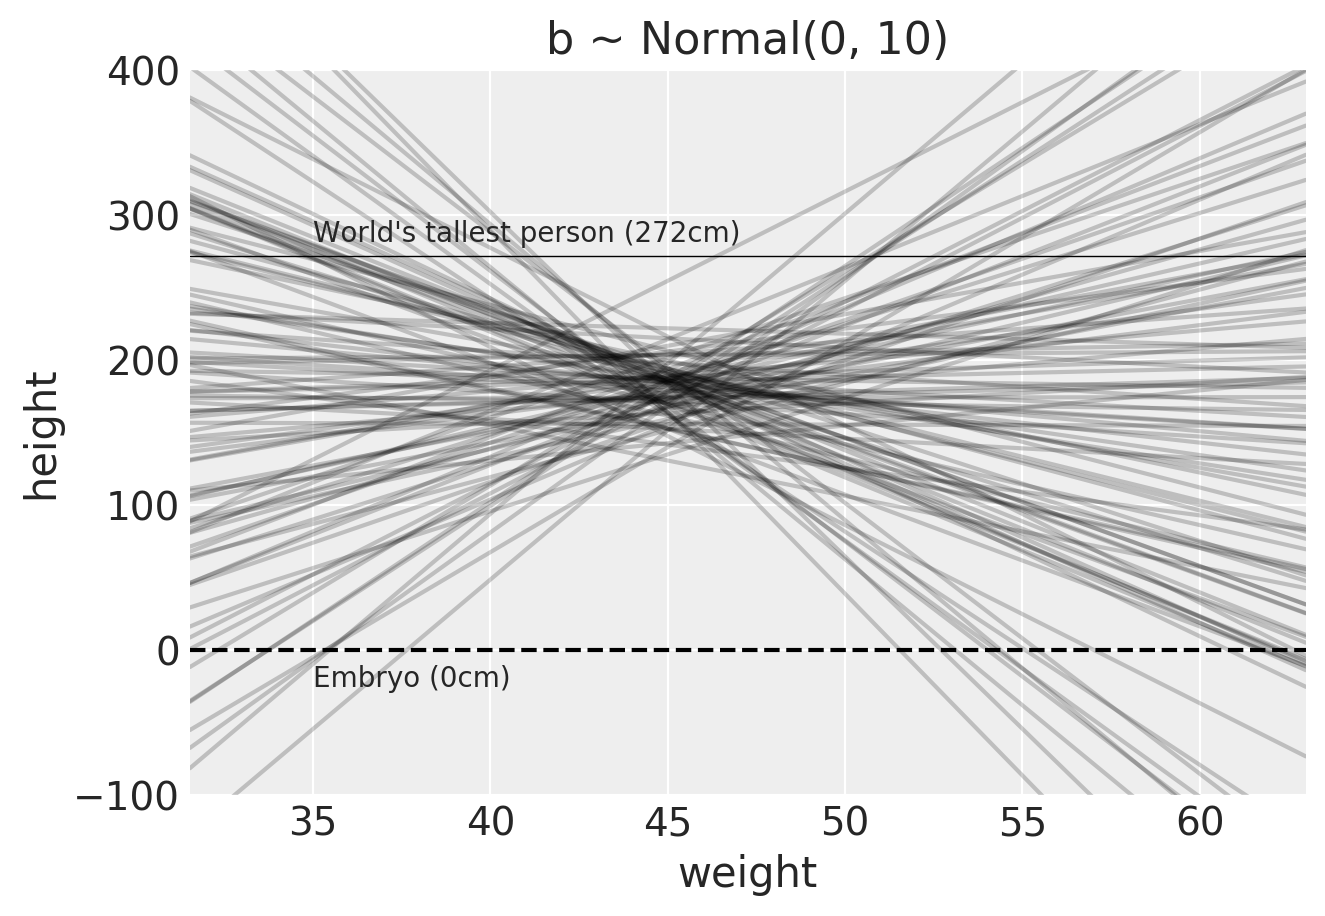

In [79]:
# And then plotting them

plt.subplot(xlim=(d2.weight.min(), d2.weight.max()), ylim=(-100, 400),
            xlabel="weight", ylabel="height")
plt.axhline(y=0, c="k", ls="--")
plt.axhline(y=272, c="k", ls="-", lw=0.5)
plt.title("b ~ Normal(0, 10)")
xbar = d2.weight.mean()
x = np.linspace(d2.weight.min(), d2.weight.max(), 101)
for i in range(N):
    plt.plot(x, a[i] + b[i] * (x - xbar), "k", alpha=0.2);
    
plt.text(x=35, y=282, s="World's tallest person (272cm)")
plt.text(x=35, y=-25, s="Embryo (0cm)");

'---' represents a zero - no one is shorter than this & also is shown the line for world's tallest person.

Clearly, the lines are showing unnatural relationships therefore befoe we have even see the data, this is a bad model. Again prior predictive checks are coming in handy !

## Code 4.40

We use some common sense here, we know that average height increases with average weight (to some extent and to a certain point) therefore we must restrict it to positive values only. 

Earlier we used Normal distribution for beta but a better one is LogNormal

$\beta \sim LogNormal(0,1)$

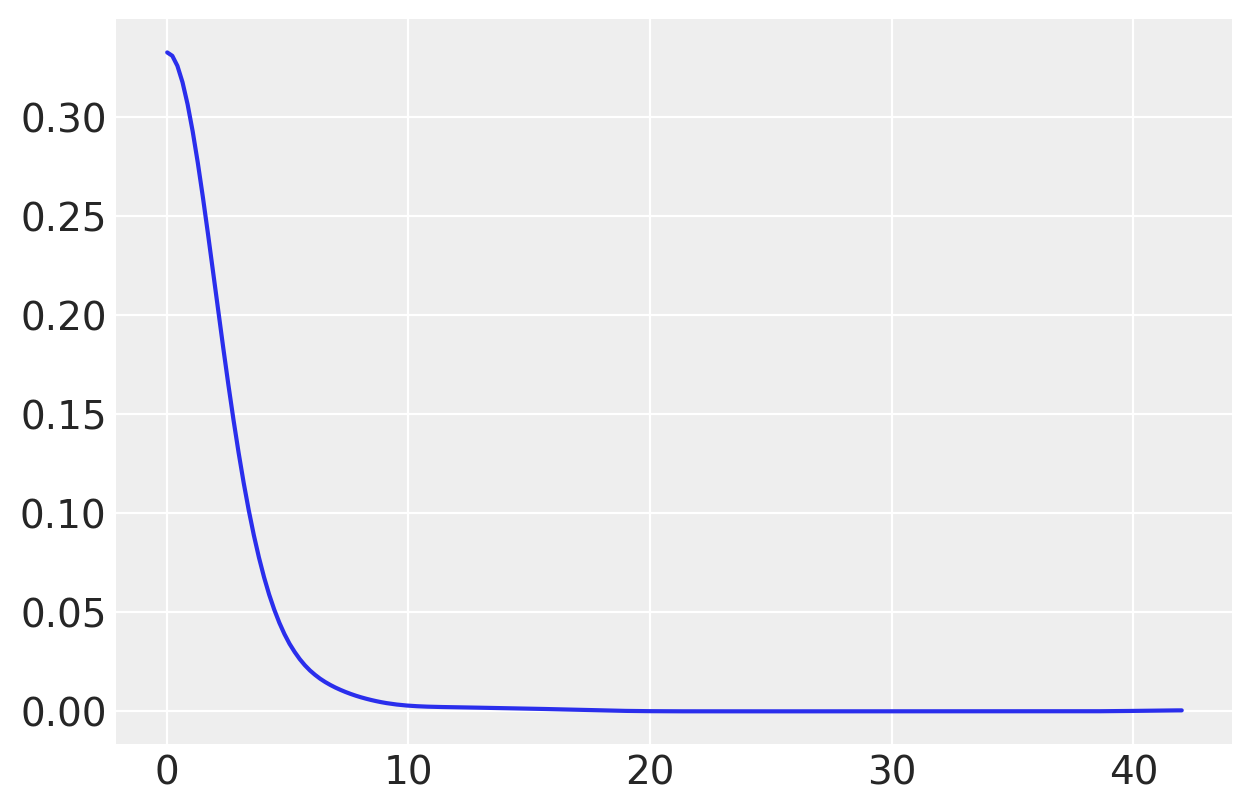

In [80]:
b = tfd.LogNormal(loc=0., scale=1.).sample(1000)
az.plot_kde(b);

## Code 4.41

Doing the prior predictive check again where $\beta$ is LogNormal

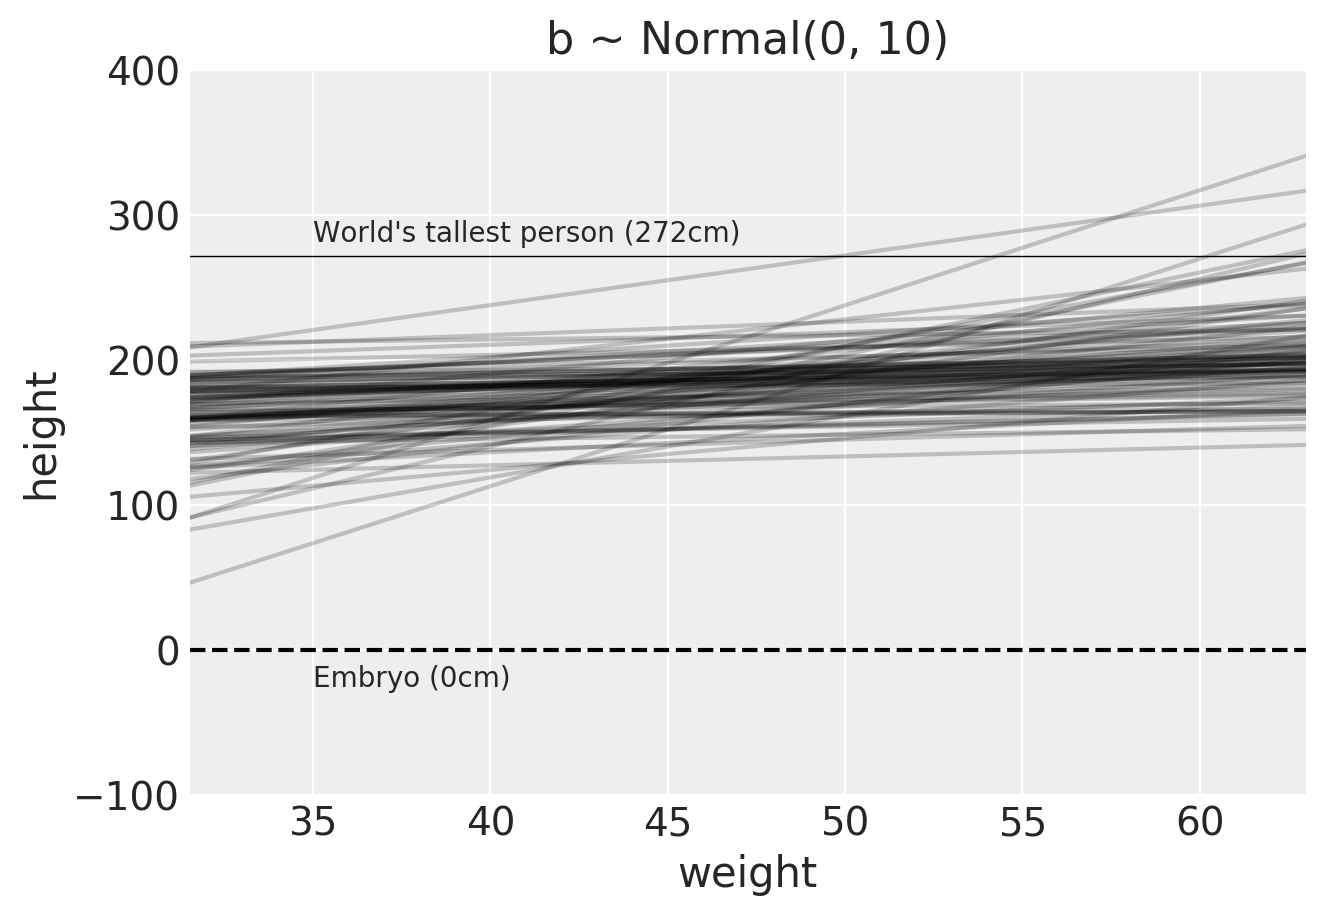

In [84]:
# We are simulating a bunch of lines here 
tf.compat.v1.random.set_random_seed(2971)

a = tfd.Normal(loc=178.0, scale=20.0).sample(100)
b = tfd.LogNormal(loc=0., scale=1.0).sample(100)

plt.subplot(xlim=(d2.weight.min(), d2.weight.max()), ylim=(-100, 400),
            xlabel="weight", ylabel="height")
plt.axhline(y=0, c="k", ls="--")
plt.axhline(y=272, c="k", ls="-", lw=0.5)
plt.title("b ~ Normal(0, 10)")
xbar = d2.weight.mean()
x = np.linspace(d2.weight.min(), d2.weight.max(), 101)
for i in range(N):
    plt.plot(x, a[i] + b[i] * (x - xbar), "k", alpha=0.2);
    
plt.text(x=35, y=282, s="World's tallest person (272cm)")
plt.text(x=35, y=-25, s="Embryo (0cm)");

Now this is much sensible plot; nearly all lines in the joint prior for $\alpha$ & $\beta$ are now in human reason.

## Code 4.42

Time to build the model again with all the new things we have discovered and updates discussed above

In [149]:
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d2 = d[d.age > 18]

# define the average height
x_bar = d2.weight.mean()

# Fit the model
def joint_log_prob_model(alpha, beta, sigma, weight_data, height_data):
    
  # stochastic variables
  alpha_dist = tfd.Normal(loc=178.0, scale=20.0)
  beta_dist =  tfd.LogNormal(loc=0.0, scale=1.0)  
  sigma_dist = tfd.Uniform(low=0., high=50.)

  # deterministic variable
  mu =  alpha + beta * (weight_data - x_bar)    

  height_dist = tfd.Normal(loc=mu, scale=sigma)
  
  return (
      alpha_dist.log_prob(alpha) +
      beta_dist.log_prob(beta) +      
      sigma_dist.log_prob(sigma) +           
      tf.reduce_sum(height_dist.log_prob(height_data)) 
  )

def unnormalized_posterior(alpha, beta, sigma):
    return joint_log_prob_model(alpha, beta, sigma, d2.weight.values, d2.height.values)

results = sample_mcmc_hmc(unnormalized_posterior, inits={ 'alpha': 120., 'beta': 0.3 , 'sigma' : 4.})

sample_alpha, sample_beta, sample_sigma = results

summary_dict = {
    'alpha' : sample_alpha.numpy(),
    'beta'  : sample_beta.numpy(),    
    'sigma' : sample_sigma.numpy(),
}

az.summary(summary_dict, round_to=2, kind='stats')

,mean,sd,hpd_3%,hpd_97%
alpha,154.65,0.28,154.09,155.16
beta,0.91,0.04,0.83,0.99
sigma,5.14,0.20,4.79,5.53


## Code 4.43  (Skip, code is not working)

Here the author talks about using log($\beta$) instead of just $\beta$ and says that the results will be same. 

But I did not find/understand the reason for it.

In [112]:
# TODO - Not working; some float32 vs float64 mess that I 
# can not seem to figure out !

# Fit the model
def joint_log_prob_model(alpha, log_beta, sigma, weight_data, height_data):
    
  # stochastic variables
  alpha_dist = tfd.Normal(loc=178.0, scale=20.0)
  log_beta_dist =  tfd.Normal(loc=0.0, scale=1.0)  
  sigma_dist = tfd.Uniform(low=0., high=50.)

    
  alpha = tf.cast(alpha, dtype=tf.float32)
  log_beta = tf.cast(log_beta, dtype=tf.float32)
  sigma = tf.cast(sigma, dtype=tf.float32)

  exp_value = tf.cast(tf.exp(log_beta), dtype=tf.float32)

  print(exp_value)

    
  # deterministic variable
  mu =  tf.cast(alpha, dtype=tf.float32) + exp_value * tf.cast((weight_data - x_bar), dtype=tf.float32)

  height_dist = tfd.Normal(loc=mu, scale=sigma)
  
  return (
      alpha_dist.log_prob(alpha) +
      log_beta_dist.log_prob(log_beta) +      
      sigma_dist.log_prob(sigma) +           
      tf.reduce_sum(height_dist.log_prob(height_data)) 
  )

def unnormalized_posterior(alpha, beta, sigma):
    return joint_log_prob_model(alpha, beta, sigma, d2.weight.values, d2.height.values)

log_beta_init_value = np.log(0.3)

print(log_beta_init_value)

results = sample_mcmc_hmc(unnormalized_posterior, inits={ 'alpha': 120., 'log_beta': log_beta_init_value , 'sigma' : 4.})

sample_alpha, sample_beta, sample_sigma = results

summary_dict = {
    'alpha' : sample_alpha.numpy(),
    'log_beta'  : sample_beta.numpy(),    
    'sigma' : sample_sigma.numpy(),
}

az.summary(summary_dict, round_to=2, kind='stats')

-1.2039728043259361
Tensor("mcmc_sample_chain/simple_step_size_adaptation___init__/_bootstrap_results/mh_bootstrap_results/hmc_kernel_bootstrap_results/maybe_call_fn_and_grads/value_and_gradients/Exp:0", shape=(), dtype=float32)
Tensor("mcmc_sample_chain/simple_step_size_adaptation___init__/_bootstrap_results/mh_bootstrap_results/hmc_kernel_bootstrap_results/maybe_call_fn_and_grads/value_and_gradients/value_and_gradient/Exp:0", shape=(), dtype=float32)
Tensor("leapfrog_integrate_one_step/maybe_call_fn_and_grads/value_and_gradients/Exp:0", shape=(), dtype=float32)
Tensor("leapfrog_integrate_one_step/maybe_call_fn_and_grads/value_and_gradients/value_and_gradient/Exp:0", shape=(), dtype=float32)


TypeError: in converted code:

    <ipython-input-5-08ddf95a54e5>:58 run_hmc_chain  *
        results = tfp.mcmc.sample_chain(
    /Users/ksachdeva/Desktop/Dev/myoss/rethinking-tensorflow-probability/env/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:359 sample_chain
        parallel_iterations=parallel_iterations)
    /Users/ksachdeva/Desktop/Dev/myoss/rethinking-tensorflow-probability/env/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/internal/util.py:395 trace_scan
        parallel_iterations=parallel_iterations)
    /Users/ksachdeva/Desktop/Dev/myoss/rethinking-tensorflow-probability/env/lib/python3.7/site-packages/tensorflow_core/python/ops/control_flow_ops.py:2478 while_loop_v2
        return_same_structure=True)
    /Users/ksachdeva/Desktop/Dev/myoss/rethinking-tensorflow-probability/env/lib/python3.7/site-packages/tensorflow_core/python/ops/control_flow_ops.py:2675 while_loop
        back_prop=back_prop)
    /Users/ksachdeva/Desktop/Dev/myoss/rethinking-tensorflow-probability/env/lib/python3.7/site-packages/tensorflow_core/python/ops/while_v2.py:194 while_loop
        add_control_dependencies=add_control_dependencies)
    /Users/ksachdeva/Desktop/Dev/myoss/rethinking-tensorflow-probability/env/lib/python3.7/site-packages/tensorflow_core/python/framework/func_graph.py:978 func_graph_from_py_func
        func_outputs = python_func(*func_args, **func_kwargs)
    /Users/ksachdeva/Desktop/Dev/myoss/rethinking-tensorflow-probability/env/lib/python3.7/site-packages/tensorflow_core/python/ops/while_v2.py:172 wrapped_body
        outputs = body(*_pack_sequence_as(orig_loop_vars, args))
    /Users/ksachdeva/Desktop/Dev/myoss/rethinking-tensorflow-probability/env/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/internal/util.py:384 _body
        state = loop_fn(state, elems_array.read(i))
    /Users/ksachdeva/Desktop/Dev/myoss/rethinking-tensorflow-probability/env/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:343 _trace_scan_fn
        parallel_iterations=parallel_iterations)
    /Users/ksachdeva/Desktop/Dev/myoss/rethinking-tensorflow-probability/env/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/internal/util.py:317 smart_for_loop
        parallel_iterations=parallel_iterations
    /Users/ksachdeva/Desktop/Dev/myoss/rethinking-tensorflow-probability/env/lib/python3.7/site-packages/tensorflow_core/python/ops/control_flow_ops.py:2478 while_loop_v2
        return_same_structure=True)
    /Users/ksachdeva/Desktop/Dev/myoss/rethinking-tensorflow-probability/env/lib/python3.7/site-packages/tensorflow_core/python/ops/control_flow_ops.py:2675 while_loop
        back_prop=back_prop)
    /Users/ksachdeva/Desktop/Dev/myoss/rethinking-tensorflow-probability/env/lib/python3.7/site-packages/tensorflow_core/python/ops/while_v2.py:194 while_loop
        add_control_dependencies=add_control_dependencies)
    /Users/ksachdeva/Desktop/Dev/myoss/rethinking-tensorflow-probability/env/lib/python3.7/site-packages/tensorflow_core/python/framework/func_graph.py:978 func_graph_from_py_func
        func_outputs = python_func(*func_args, **func_kwargs)
    /Users/ksachdeva/Desktop/Dev/myoss/rethinking-tensorflow-probability/env/lib/python3.7/site-packages/tensorflow_core/python/ops/while_v2.py:172 wrapped_body
        outputs = body(*_pack_sequence_as(orig_loop_vars, args))
    /Users/ksachdeva/Desktop/Dev/myoss/rethinking-tensorflow-probability/env/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/internal/util.py:315 <lambda>
        body=lambda i, *args: [i + 1] + list(body_fn(*args)),
    /Users/ksachdeva/Desktop/Dev/myoss/rethinking-tensorflow-probability/env/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/simple_step_size_adaptation.py:325 one_step
        current_state, inner_results)
    /Users/ksachdeva/Desktop/Dev/myoss/rethinking-tensorflow-probability/env/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/hmc.py:547 one_step
        current_state, previous_kernel_results)
    /Users/ksachdeva/Desktop/Dev/myoss/rethinking-tensorflow-probability/env/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/metropolis_hastings.py:193 one_step
        previous_kernel_results.accepted_results)
    /Users/ksachdeva/Desktop/Dev/myoss/rethinking-tensorflow-probability/env/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/hmc.py:748 one_step
        independent_chain_ndims),
    /Users/ksachdeva/Desktop/Dev/myoss/rethinking-tensorflow-probability/env/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/hmc.py:878 _compute_log_acceptance_correction
        current_kinetic = tf.add_n([sum_sq(v) for v in current_momentums])
    /Users/ksachdeva/Desktop/Dev/myoss/rethinking-tensorflow-probability/env/lib/python3.7/site-packages/tensorflow_core/python/util/dispatch.py:180 wrapper
        return target(*args, **kwargs)
    /Users/ksachdeva/Desktop/Dev/myoss/rethinking-tensorflow-probability/env/lib/python3.7/site-packages/tensorflow_core/python/ops/math_ops.py:3053 add_n
        return gen_math_ops.add_n(inputs, name=name)
    /Users/ksachdeva/Desktop/Dev/myoss/rethinking-tensorflow-probability/env/lib/python3.7/site-packages/tensorflow_core/python/ops/gen_math_ops.py:420 add_n
        "AddN", inputs=inputs, name=name)
    /Users/ksachdeva/Desktop/Dev/myoss/rethinking-tensorflow-probability/env/lib/python3.7/site-packages/tensorflow_core/python/framework/op_def_library.py:440 _apply_op_helper
        raise TypeError("%s that don't all match." % prefix)

    TypeError: Tensors in list passed to 'inputs' of 'AddN' Op have types [float32, float64, float32] that don't all match.


## Code 4.44

In [114]:
sample_alpha, sample_beta, sample_sigma = results

summary_dict = {
    'alpha' : sample_alpha.numpy(),
    'beta'  : sample_beta.numpy(),    
    'sigma' : sample_sigma.numpy(),
}

az.summary(summary_dict, round_to=2, kind='stats')

,mean,sd,hpd_3%,hpd_97%
alpha,154.65,0.28,154.09,155.16
beta,0.91,0.04,0.83,0.99
sigma,5.14,0.20,4.79,5.53


## Code 4.45

In [115]:
samples_flat = np.stack([sample_alpha, sample_beta, sample_sigma], axis=0)
alpha_mean = np.mean(sample_alpha, dtype=np.float64)
beta_mean = np.mean(sample_beta, dtype=np.float64)
sigma_mean = np.mean(sample_sigma, dtype=np.float64)
cov = np.cov(samples_flat)

alpha_mean, beta_mean, sigma_mean, cov

(154.64513651428223,
 0.9058311521172524,
 5.144274731731414,
 array([[ 7.92349414e-02, -5.52117343e-05, -1.59732481e-04],
        [-5.52117343e-05,  1.92461518e-03,  1.95172413e-04],
        [-1.59732481e-04,  1.95172413e-04,  3.88735171e-02]]))

In [116]:
np.round(cov,3)

array([[ 0.079, -0.   , -0.   ],
       [-0.   ,  0.002,  0.   ],
       [-0.   ,  0.   ,  0.039]])

We see very little covariance among the parameters in this case. This lack of covariance among the parameters results from something called **Centering**

## Code 4.46

This snippet appears in the section titled **Plotting posterior inference against the data**. 

Author examplins that plotting is extremely useful in see when key observations or patterns in the plotted data are not close to the model's pediction.

In this snippet, we start with the simple version of the task (i.e. plotting) by superimposing the posterior mean values over the height & weight data. Later more and more information to prediction plots will be added until the entire posterior distribution is covered.


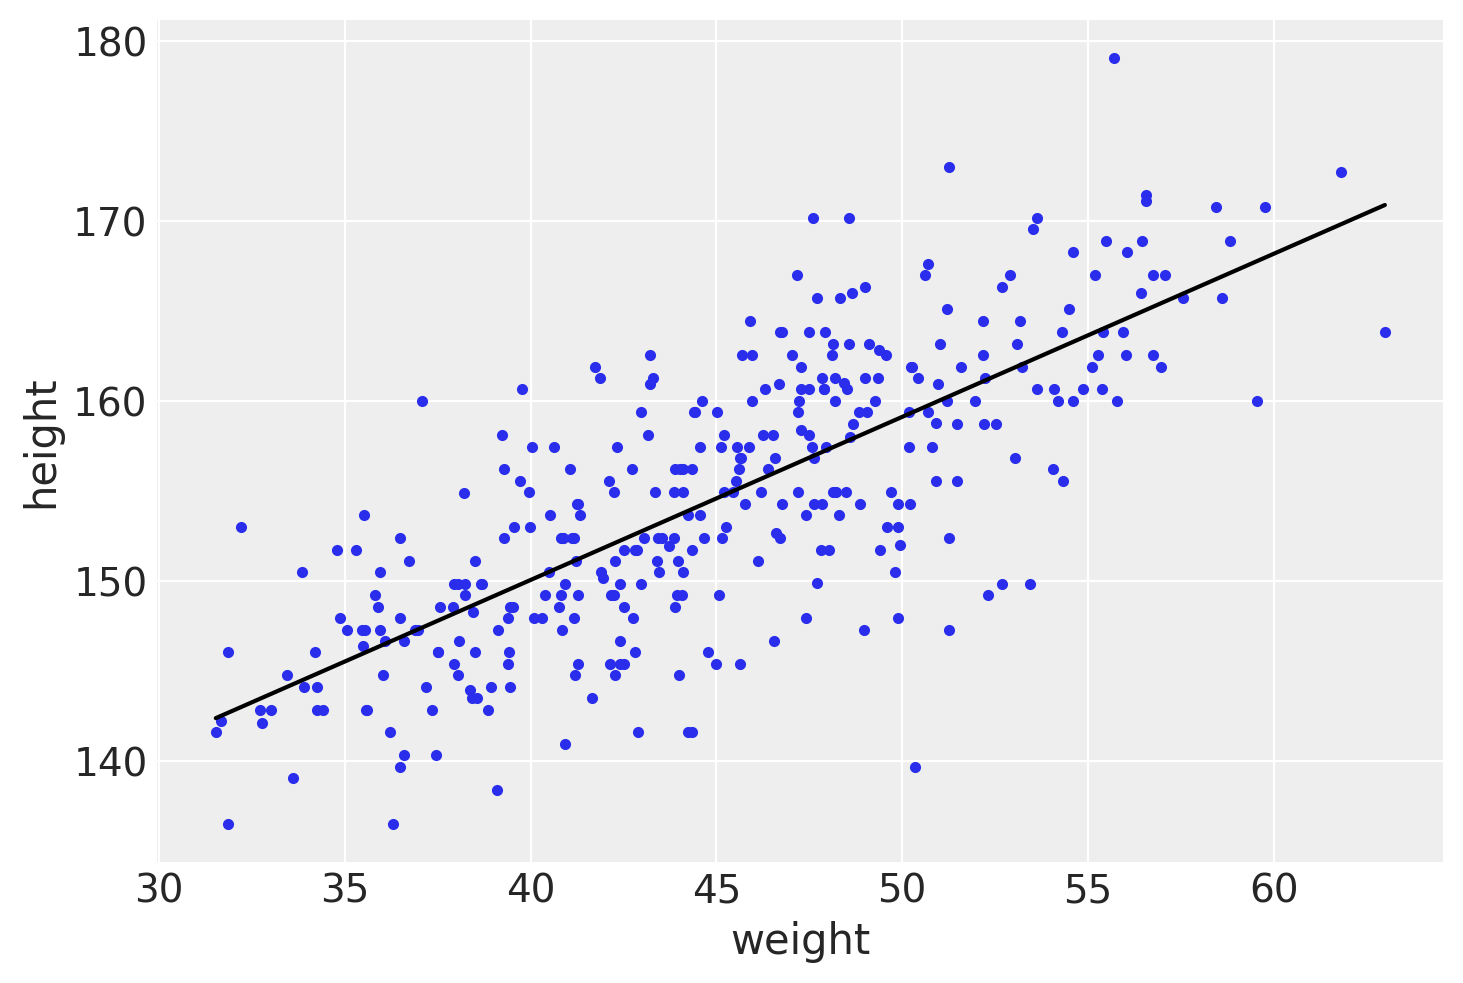

In [118]:
# Let's try just the raw data and a single line

# Raw data is shown using the dots
# The line shows the model that makes use of average values of alpha and beta

az.plot_pair(d2[["weight", "height"]].to_dict(orient="list"))

a_map = np.mean(sample_alpha)
b_map = np.mean(sample_beta)
x = np.linspace(d2.weight.min(), d2.weight.max(), 101)
plt.plot(x, a_map + b_map * (x - xbar), "k");

Now above line is a good line, quite plausible line (model) actually. However, we must not forget that there are an infinite number of other highly plausible lines near it. So we would next try to get them as well !

## Code 4.47 TODO : Add notes

In [123]:
# Looking at few values/samples from our posterior
pd.DataFrame.from_dict(summary_dict).head(5)

,alpha,beta,sigma
0,154.240997,0.851726,5.221540
1,154.240997,0.851726,5.221540
2,154.240997,0.851726,5.221540
3,154.194519,0.871307,4.877145
4,154.194519,0.871307,4.877145


## Code 4.48

In [147]:
N = 10
dN = d2[:N]

def unnormalized_posterior_dn(alpha, beta, sigma):
    return joint_log_prob_model(alpha, beta, sigma, dN.weight.values, dN.height.values)

results_n = sample_mcmc_hmc(unnormalized_posterior_dn, inits={ 'alpha': 120., 'beta': 0.3 , 'sigma' : 4.})

sample_alpha_n, sample_beta_n, sample_sigma_n = results_n

summary_dict_n = {
    'alpha' : sample_alpha_n.numpy(),
    'beta'  : sample_beta_n.numpy(),    
    'sigma' : sample_sigma_n.numpy(),
}

az.summary(summary_dict_n, round_to=2, kind='stats')

,mean,sd,hpd_3%,hpd_97%
alpha,152.41,1.64,148.49,155.14
beta,0.90,0.15,0.63,1.25
sigma,5.38,1.94,2.84,8.58


## Code 4.49  TODO : plot with more data i.e. N = 10,50,150,352

Now let's plot 20 of these lines, to see what the uncertainity looks like

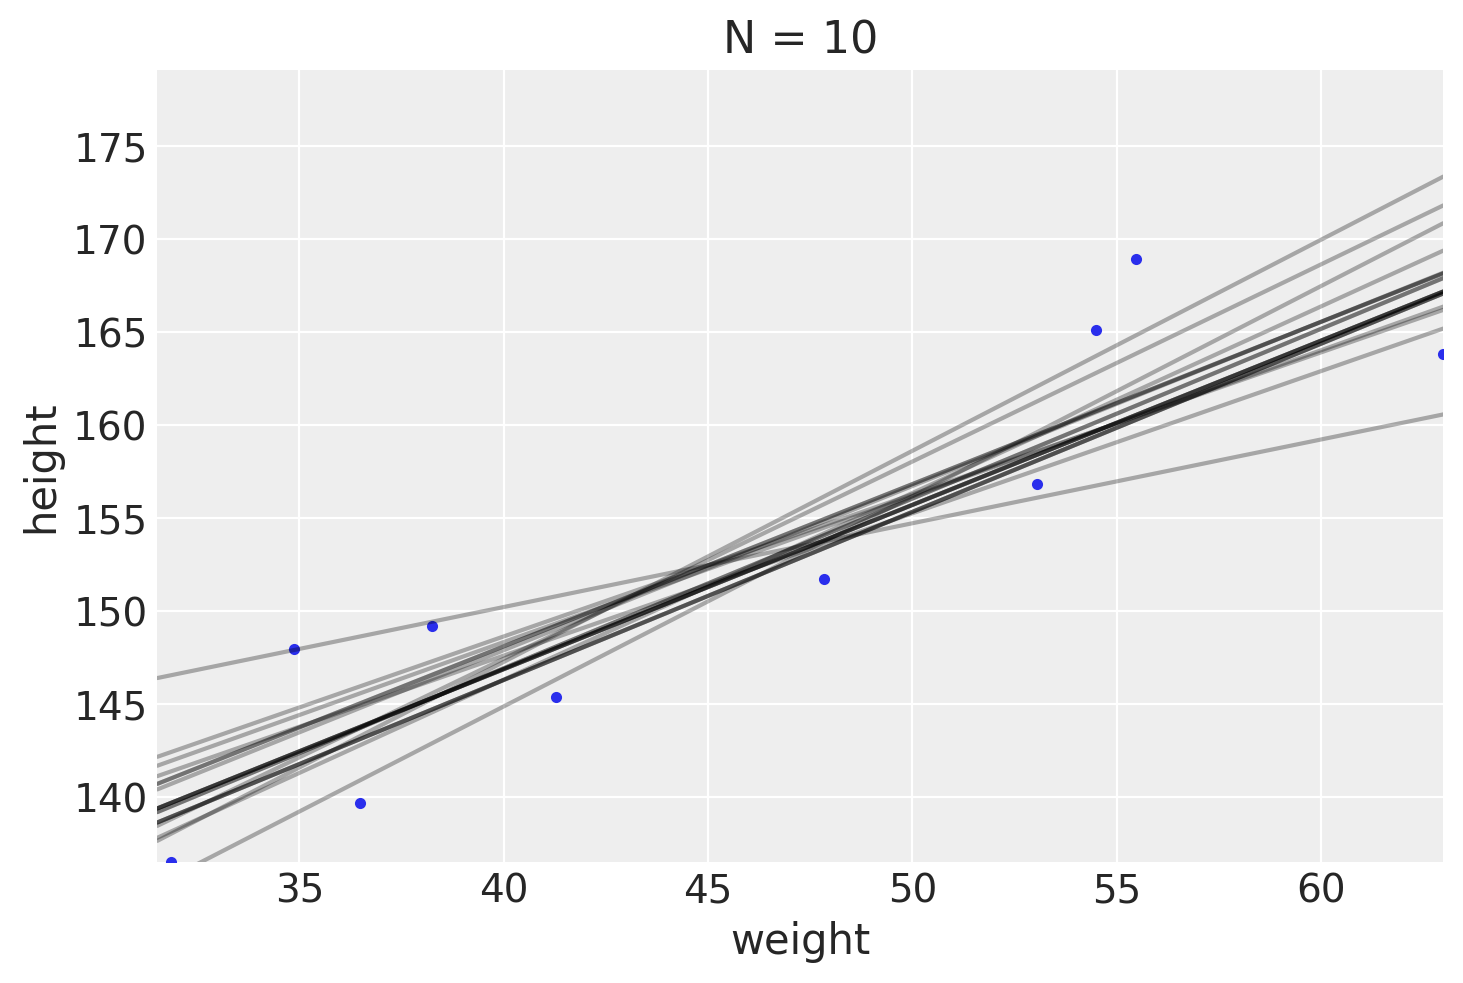

In [148]:
twenty_random_samples = pd.DataFrame.from_dict(summary_dict_n).sample(20).to_dict('list')

# display raw data and sample size
ax = az.plot_pair(dN[["weight", "height"]].to_dict(orient="list"))
ax.set(xlim=(d2.weight.min(), d2.weight.max()),
       ylim=(d2.height.min(), d2.height.max()), title="N = {}".format(N))

# plot the lines, with transparency
x = np.linspace(d2.weight.min(), d2.weight.max(), 101)
for i in range(20):
    plt.plot(x, twenty_random_samples["alpha"][i] + twenty_random_samples["beta"][i] * (x - dN.weight.mean()),
             "k", alpha=0.3)

## Code 4.50 & 4.51

Here we focus on a single weight value of 50 KG.



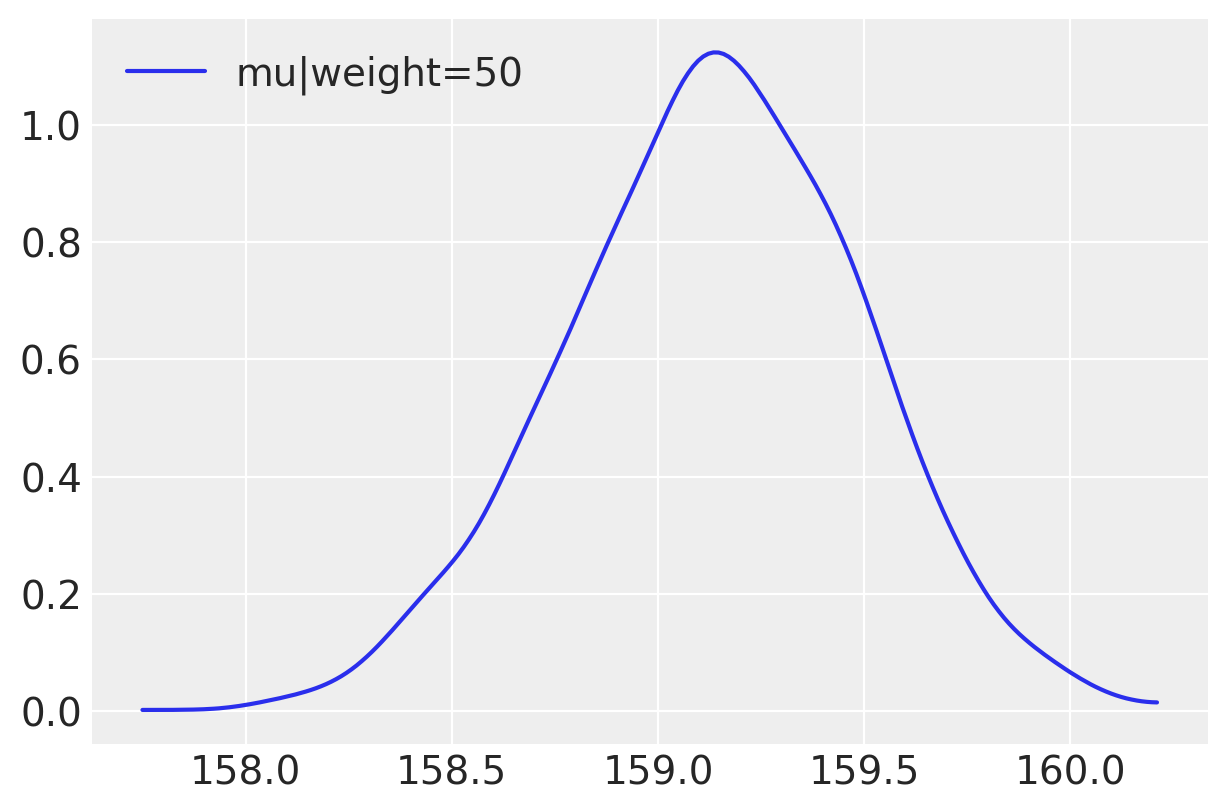

In [150]:
mu_at_50 = sample_alpha + sample_beta * ( 50 - x_bar )

az.plot_kde(mu_at_50, label="mu|weight=50")

## Code 4.52


In [151]:
az.hpd(mu_at_50.numpy())

array([158.43652, 159.7725 ], dtype=float32)